In [1]:
%pip install shap
%pip install eli5
%pip install lightgbm
%pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
#importing modules

import warnings
warnings.filterwarnings('ignore')
import time
t = time.time()

print('Importing startred...')

# basic moduele
import os
import numpy as np
import pandas as pd
import re
from scipy import stats
from random import randint

# visualization moduels
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno


# preprocessing modules
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     StratifiedKFold,
                                    cross_val_score)

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler)

from sklearn.feature_selection import SelectFromModel


# metrics
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error)


# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor,
                              RandomForestRegressor,
                              VotingRegressor,
                              GradientBoostingRegressor)
from xgboost import XGBRegressor
from lightgbm import (LGBMRegressor,
                      early_stopping)

from sklearn.base import clone ## sklearn base models for stacked ensemble model

#Interpretiability of the model
import shap
#import eli5
#from eli5.sklearn import PermutationImportance


## miss
from sklearn.pipeline import make_pipeline



print('Done,All the required modules are imported. Time elapsed: {}sec'.format(time.time()-t))

Importing startred...
Done,All the required modules are imported. Time elapsed: 4.954912900924683sec


In [4]:
# loading dataset
df = pd.read_csv('diamonds.csv', encoding = 'utf-8', delimiter = ',')
print("Done. Shape of the Dataset is {}".format(df.shape))
df.head()

Done. Shape of the Dataset is (53940, 11)


Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

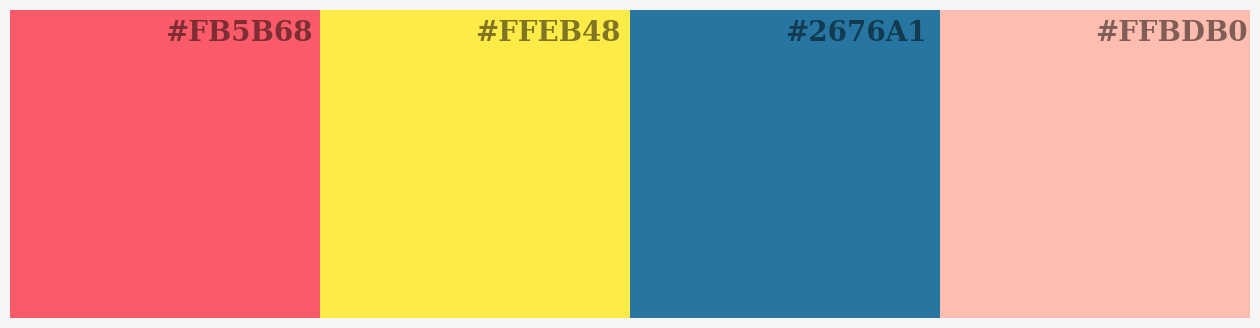

In [8]:
# color palette

#black  '#1F0C07',
#light pink '#FA74BF'

colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("",colors)


sns.palplot(colors, size = 4)
plt.text(-0.75,-0.75, '',{'font':'serif', 'size':24, 'weight':'bold'})
plt.text(-0.75,-0.65, '',{'font':'serif', 'size':16},alpha = 0.7)
for idx,values in enumerate(colors):
    plt.text(idx,-0.40, colors[idx],{'font':'serif', 'size':20, 'weight':'bold'}, alpha = 0.5)
plt.gcf().set_facecolor('#f5f6f6')
plt.box(None)
plt.axis('off')
plt.text(3,0.65,'',{'font':'serif', 'size':9,  'color':'grey'})
plt.show()

In [11]:
## information and descriptive statistical dataframes

## df.drop(columns = ['Unnamed: 0'], inplace = True) ### unnecessary coloumn, repeated index

info_df = (pd.DataFrame({'Features':df.columns,'Non Null Count':df.count(), 'Null Count': df.isnull().sum(), 'Datatypes':df.dtypes,})
        .sort_values(by='Datatypes').reset_index(drop = True))
stats = df.describe(include = 'all').T.reset_index()



tota = pd.merge( info_df,stats, right_on = 'index',left_on = 'Features',how = 'inner').drop(columns = ['index', 'count']).round(0)
tota = tota.fillna(0)



colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
tota.style.bar(subset = ['mean', 'std', 'min', '25%','50%','75%', 'max'],axis = 1 ,color = colors[2])\
    .format({'mean':"{:20,.0f}",
             'std':"{:20,.0f}",
             'min':"{:20,.0f}",
             '25%':"{:20,.0f}",
             '50%':"{:20,.0f}",
             '75%':"{:20,.0f}",
             'max':"{:20,.0f}"})\
    .format({"Features": lambda x:  x.upper()},
           )\
    .set_properties(**{'background-color': '#f9f9f9',
                                    'color': 'black',
                                    'border-color': 'white'})

In [12]:
### Statistics dataframe creation

des_stats = df.describe(exclude = ['object']).drop(index = ['count'], axis = 0).T
skew = []
kurt = []
num_cols = df.select_dtypes(exclude = ['object']).columns
for col in num_cols:
    skew.append(df[col].skew().round(1))
    kurt.append(df[col].kurt().round(1))

stats = pd.DataFrame({'skew':skew,'kurt':kurt}, index = num_cols)

all_stats = pd.merge(left = des_stats,right = stats, left_index = True, right_index = True)

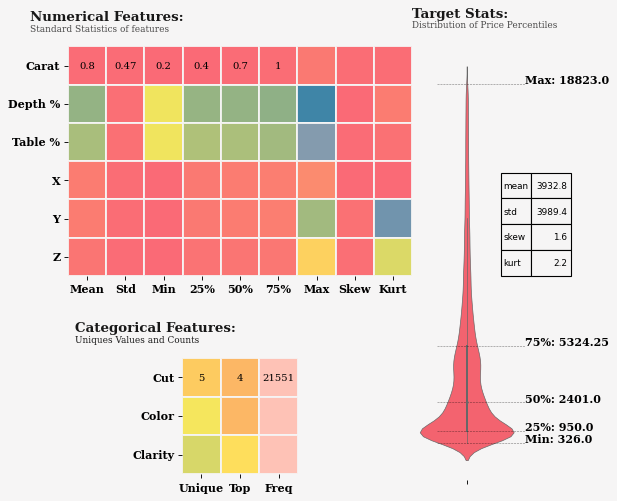

In [14]:

fig = plt.figure(figsize =(15,12), dpi = 80)
fig.patch.set_facecolor('#f6f5f5')

gs = fig.add_gridspec(8,8)
gs.update(wspace = 0, hspace = 3)

back_ground = '#f6f5f5'
ax1 = fig.add_subplot(gs[0:3,0:3])
ax2 = fig.add_subplot(gs[0:5,3])
ax3 = fig.add_subplot(gs[3:5,1:2])
ax4 = fig.add_subplot(gs[0:3,3])

axes = [ax1,ax2, ax3]

for ax in axes:
    for loc in ['left','right','top','bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_facecolor('#f6f5f5')


#colormap for visualization
colormap  = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


#### statistics of numerical features
sns.heatmap(all_stats.drop(index = ['price']),
            annot = True, ax = ax1,
            vmin = -0, vmax = 120,
            square = True, linewidths = 0.09,linecolor = '#f6f5f5',
            cbar = False,
            cmap =colormap, annot_kws={'font':'serif', 'size':9, 'weight':'normal', 'color':'black'}, alpha = 0.9)

#### statistics of target
#ax4 = ax2.twinx()
sns.violinplot(y = df['price'], ax = ax2, palette= [colors[0]],inner = 'box', saturation = 0.9, linewidth = 0.6, **{'linecolor' :'black' })


## labeling stats in violin plot
pr = df['price'].describe().drop(index = ['count', 'mean','std'], axis = 0)

for idx,value in pr.items():
    ax2.plot([-0.25,0.5], [value,value], **{'linewidth': 0.5, 'linestyle': '--','color':'black' }, alpha = 0.5 )
    if idx == 'max':
        idx = 'Max'
    elif idx == 'min':
        idx = 'Min'
    else:
        idx = idx
    ax2.text(0.5,value,'{}: {}'.format(idx,value) ,{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})


ax2.axes.get_yaxis().set_visible(False)

### price stats table
price_stats = all_stats.T['price'].to_frame().round(1)
price_stats = (price_stats.T[['mean', 'std', 'skew', 'kurt']]).T
bbox = [1, 0, 0.35, 0.45]
ax4.table(cellText = price_stats.values, rowLabels = price_stats.index,
          bbox=bbox,cellColours = np.array(['#f6f5f5','#f6f5f5','#f6f5f5','#f6f5f5']).reshape(-1,1),
          rowColours = ['#f6f5f5','#f6f5f5','#f6f5f5','#f6f5f5'])

ax4.axis('off')

#### statistics of categorical features
sx = df.describe(exclude = ['int64', 'float64','float']).drop(index = ['count'], axis = 0).T
sx['top']= ['4', '4', '6']
sx = sx.astype(int)

sns.heatmap(sx,annot = True,fmt = '1.0f',vmin = -0, vmax = 20,ax = ax3,
            square = True, linewidths = 0.09,cbar = False,linecolor = '#f6f5f5',
            cmap =colormap, annot_kws={'font':'serif', 'size':9, 'weight':'normal', 'color':'black'}, alpha =0.9)

#### axis and labeling
ax1.set_yticklabels(labels = ['Carat', 'Depth %', 'Table %','X', 'Y', 'Z'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})
ax1.set_xticklabels(labels = ['Mean','Std','Min','25%','50%','75%', 'Max','Skew','Kurt'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})

ax3.set_yticklabels(labels = ['Cut', 'Color', 'Clarity'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})
ax3.set_xticklabels(labels = ['Unique', 'Top', 'Freq'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})

### titles
ax1.text(-1., -0.7 , 'Numerical Features:',{'font':'serif', 'size':12, 'weight':'bold','color':'black'}, alpha = 0.9)
ax1.text(-1., -0.4, 'Standard Statistics of features',{'font':'serif', 'size':8, 'color':'black'}, alpha = 0.7)

ax2.text(-0.47, 22250 , 'Target Stats: ',{'font':'serif', 'size':12, 'weight':'bold','color':'black'}, alpha = 0.9)
ax2.text(-0.47, 21750 , 'Distribution of Price Percentiles',{'font':'serif', 'size':8,'color':'black'}, alpha = 0.7)

ax3.text(-2.75, -0.7 , 'Categorical Features:',{'font':'serif', 'size':12, 'weight':'bold','color':'black'}, alpha = 0.9)
ax3.text(-2.75, -0.4 , 'Uniques Values and Counts',{'font':'serif', 'size':8,  'color':'black'}, alpha = 0.9)

ax1.text(-2,-2.7,'',{'font':'serif', 'size':20, 'weight':'bold', 'color':'black'})
ax1.text(-2,-1.6,"",{'font':'serif', 'size':11,  'color':'black'}, alpha = 0.7)

ax2.text(0,-2500,'',{'font':'serif', 'size':8,  'color':'grey'})

fig.show()



<div style = "font-family:serif; font-size: 17px;color:black">  

From Stastical overview 👨‍🏫 deduce following insights

<ol>  
 <li> <strong>Cut:</strong> Ideal cut is common with highest frequency. Cut determines ✂✂ of the jeweal as it determines the amount of light refract within the diamond and brings out that shining beauty, so, assuming this one goes  hand in hand with 💲.<br>
    <p style = "font-family: Garamond; font-size: 22px;color:#2676a1; font-weight: bold">Cut Categories: Fair, Good, Very Good, Premium, Ideal (Ordered from worst to best)</p></li>
    
 <li><strong>Clarity:</strong>SI1 grade is common with highest frequency. Clarity of the diamond is nothing but free of any intrutions or flaws. Who does not love
    flawless things? atleast me :) So, lets assume this is super important. <br> <p style = "font-family: Garamond; font-size: 22px;color:#2676a1; font-weight: bold">Clarity Categories:  I1 , SI2, SI1, VS2, VS1, VVS2, VVS1, IF (Ordered from worst to best) </p></li>
    
 <li> <strong>Color:</strong> G colorscale is common kind of diamond. Surpricingly diamond with no color are extremely rare and regard as highly valuable.       <br><p style = "font-family: Garamond; font-size: 22px;color:#2676a1; font-weight: bold">Color Categories: J, I, H, G, F, E, D  (Ordered from colored to less color, same is order of rarity)</p></li>
          
 <li> <strong>Carat:</strong> 1 carat diamonds are common, and beyond 1 carat are rare. As caret is a ⚖ parameter, finding a dinmond so heavy is very difficult and rare. It makes some sence. More the carat value, rare the diamond.</li>
                    
 <li> <strong>Depth%:</strong> It a ratio of the total depth (height of the diamond) to the table of the diamond, so, it is an empirical parmaeter, and it determinds the light prenetrations in to the diamond. As per wikipedia, as the depth increases diamond looks dull and it's value reduces. So, need furthur study. Based on cut shapes, ideal depth % should be in between (55-70)%</li>
                  
 <li><strong>Table%:</strong> It is a ratio of the truncated table on top of the diamond to whole diameter avereage. This measure the size of the diamond, does deals with the light beam penetrations as well. Based on cut shapes, ideal Table % should be in between (52-60)%</li>
                  
                  
 <li> <strong>X,Y,Z :</strong> These are dimensions in mm, Interestingly we have values of 0 as minimum, as these are table and depth parameters, its not practically possible. Based on these three dimensions Depth and Table perentages could be caclulated. There are severe outlier in these 3 columns.</li>
          
<li><strong>Price :</strong> Most of the dimonds are under 5k USD and outliers are there upto 18k USD. This is target, which is a continous distribution, and lots of paremeters are effecting this price value.</li>
</ol>
   
</div>


<div class = "alert alert-block alert-info" style = "font-family:cursive ;font-size:24px, font-color: black"> 📢 Missing values alert!!!!! Data have missing values hidden in X,Y,Z  features as zero values, if anyvalue is zero, then physically diamond don't exit. Looks like he found invincible diamonds in our data. 🛸 </div>

<p style = "font-family: cursive; font-size: 17px; font-weight:noramal; color:#2676A1 ;border-radius:5px ; background-color: #ffeb48; padding : 15px"> After though 📈 of statistics of the data, our 🤵 found there are hidden 💎s in the data, and relatively high skewed <strong>(acceptable in range of |3|)</strong> datapoints along with high kurotisis values (acceptable in range of |10|, as noramal distribution has 3) for y,z which indicated fat tail or high outliers . Our 🤵 decided to drop 🗑 Those missing values and <strong>apply 3 Standard Deviation</strong> to ✂✂ outliers. </p>

<br>
<a id = '3.3'></a>
<h2 style = "font-family: Garamond; font-size:35px; font-weight: bold; border-radius: 300px 300px; background-color: #2676A1; color : #FFEB48; padding:2px" align = 'center'>3.3 Setting up  Stage for Data Viz: Missing Diamonds, Duplicate Diamonds, And Odd diamonds </h2>
<a href = '#0' style = 'font-size:15px' align = 'right'>⏫</a>
<a href = '#3.2'style = 'font-size:15px' align = 'right'>🔼</a>
<a href = '#4' style = 'font-size:15px' align = 'right'>🔽</a>
<a href = '#7' style = 'font-size:15px' align = 'right'>⏬</a>

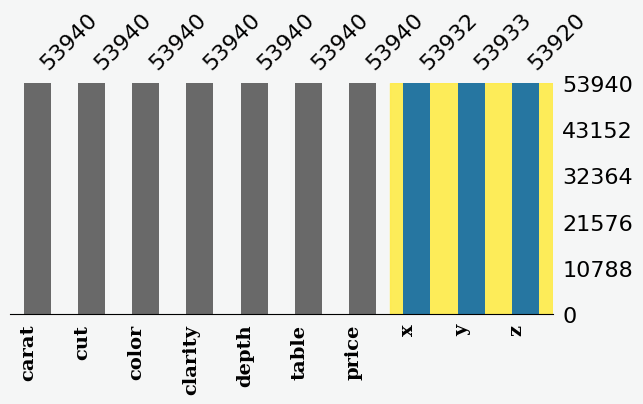

In [15]:
temp_df = df.copy()
temp_df = temp_df.replace(0,np.nan)
fig, ax = plt.subplots(figsize = (7,3), dpi= 100)
fig.patch.set_facecolor('#f5f6f6')
ax.set_facecolor('#f5f6f6')
color = [ colors[2]  if (temp_df[col].isnull().sum()) > 0 else 'dimgrey' for col in df.columns ]

ax.axvspan(xmin = 6.5, xmax = 9.5, color = '#ffeb48',alpha = 0.9)
msno.bar(df = temp_df, ax = ax,color=color, log = False)


fig.text(0.05,1.25,'', {'font':'serif', 'size':20, 'weight':'bold'})
fig.text(0.05,1.15,'', {'font':'serif', 'size':10, 'weight':'normal'}, alpha = 0.7)

ax.axes.get_yaxis().set_visible(False)
ax.set_xticklabels(ax.axes.get_xticklabels(), rotation = 90, **{'font':'serif','size':14,'weight':'bold'})

ax.spines['bottom'].set_visible(True)
fig.text(0.78,-0.13,'',{'font':'serif', 'size':8,  'color':'grey'})
fig.show()

There are missing data in X,y,z and these are very less in compared to dataset, so let's drop them.

In [16]:
### dataframe free of null values

print("Cleaning data....")
print('Shape of Dataset after without any processing: {}'.format(df.shape))
df = df[(df['x'] != 0) | (df['y'] != 0) | (df['z'] != 0)]


print('Shape of Dataset after droping null values: {}'.format(df.shape))

## checking for duplicate values
if df.duplicated().any:
    df = df.drop_duplicates()
    temp3 = df.shape[0]
    print('Duplicates exist,and Shape of Dataset after dropping duplicates: {}'.format(df.shape))
df.reset_index(drop = True, inplace = True)

orig_df = df.copy() ## lets keep it for futur comparision

Cleaning data....
Shape of Dataset after without any processing: (53940, 10)
Shape of Dataset after droping null values: (53933, 10)
Duplicates exist,and Shape of Dataset after dropping duplicates: (53788, 10)


In [18]:
#### zscore dataframe

zscore_df = df.copy().select_dtypes(exclude = 'object') # this is not yet zscore just a copy of dataframe
obj_col = zscore_df.columns

for col in obj_col:
    zscore_df[col] = np.abs((df[col] - df[col].mean())/df[col].std())


## outliers
std = 3

outliers = df[(zscore_df['x'] > std)| (zscore_df['y'] > std)| (zscore_df['z'] > std)| (zscore_df['price'] > std)| (zscore_df['depth'] > std)| (zscore_df['table'] > std)]
df = df.drop(index = outliers.index).reset_index(drop = True)



print('Outliers removing....')
print('Number of Outliers in the dataset are: {}'.format(outliers.shape[0]))
print('Shape of Dataset after removing Outliers: {}'.format(df.shape[0]))

Outliers removing....
Number of Outliers in the dataset are: 2169
Shape of Dataset after removing Outliers: 51619


In [21]:
### Statistics dataframe creation after statistical insights

des_stats = df.describe(exclude = ['object']).drop(index = ['count'], axis = 0).T
skew = []
kurt = []
num_cols = df.select_dtypes(exclude = ['object']).columns
for col in num_cols:
    skew.append(df[col].skew().round(1))
    kurt.append(df[col].kurt().round(1))

stats = pd.DataFrame({'skew':skew,'kurt':kurt}, index = num_cols)

all_stats = pd.merge(left = des_stats,right = stats, left_index = True, right_index = True)

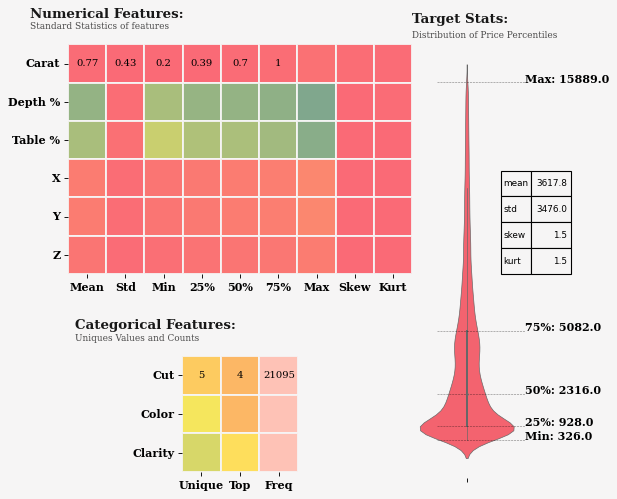

In [23]:
### Stats viualization after statistical insights

fig = plt.figure(figsize =(15,12), dpi = 80)
fig.patch.set_facecolor('#f6f5f5')

gs = fig.add_gridspec(8,8)
gs.update(wspace = 0, hspace = 3)

back_ground = '#f6f5f5'
ax1 = fig.add_subplot(gs[0:3,0:3])
ax2 = fig.add_subplot(gs[0:5,3])
ax3 = fig.add_subplot(gs[3:5,1:2])
ax4 = fig.add_subplot(gs[0:3,3])

axes = [ax1,ax2, ax3]

for ax in axes:
    for loc in ['left','right','top','bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_facecolor('#f6f5f5')


#colormap for visualization
colormap  = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


#### statistics of numerical features
sns.heatmap(all_stats.drop(index = ['price']),
            annot = True, ax = ax1,
            vmin = -0, vmax = 120,
            square = True, linewidths = 0.09,linecolor = '#f6f5f5',
            cbar = False,
            cmap =colormap, annot_kws={'font':'serif', 'size':9, 'weight':'normal', 'color':'black'}, alpha = 0.9)

#### statistics of target
#ax4 = ax2.twinx()
sns.violinplot(y = df['price'], ax = ax2, palette= [colors[0]],inner = 'box', saturation = 0.9, linewidth = 0.6, **{'linecolor' :'black' })


## labeling stats in violin plot
pr = df['price'].describe().drop(index = ['count', 'mean','std'], axis = 0)

for idx,value in pr.items():
    ax2.plot([-0.25,0.5], [value,value], **{'linewidth': 0.5, 'linestyle': '--','color':'black' }, alpha = 0.5 )
    if idx == 'max':
        idx = 'Max'
    elif idx == 'min':
        idx = 'Min'
    else:
        idx = idx
    ax2.text(0.5,value,'{}: {}'.format(idx,value) ,{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})


ax2.axes.get_yaxis().set_visible(False)

### price stats table
price_stats = all_stats.T['price'].to_frame().round(1)
price_stats = (price_stats.T[['mean', 'std', 'skew', 'kurt']]).T
bbox = [1, 0, 0.35, 0.45]
ax4.table(cellText = price_stats.values, rowLabels = price_stats.index,
          bbox=bbox,cellColours = np.array(['#f6f5f5','#f6f5f5','#f6f5f5','#f6f5f5']).reshape(-1,1),
          rowColours = ['#f6f5f5','#f6f5f5','#f6f5f5','#f6f5f5'])

ax4.axis('off')

#### statistics of categorical features
sx = df.describe(exclude = ['int64', 'float64','float']).drop(index = ['count'], axis = 0).T
sx['top']= ['4', '4', '6']
sx = sx.astype(int)

sns.heatmap(sx,annot = True,fmt = '1.0f',vmin = -0, vmax = 20,ax = ax3,
            square = True, linewidths = 0.09,cbar = False,linecolor = '#f6f5f5',
            cmap =colormap, annot_kws={'font':'serif', 'size':9, 'weight':'normal', 'color':'black'}, alpha =0.9)

#### axis and labeling
ax1.set_yticklabels(labels = ['Carat', 'Depth %', 'Table %','X', 'Y', 'Z'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})
ax1.set_xticklabels(labels = ['Mean','Std','Min','25%','50%','75%', 'Max','Skew','Kurt'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})

ax3.set_yticklabels(labels = ['Cut', 'Color', 'Clarity'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})
ax3.set_xticklabels(labels = ['Unique', 'Top', 'Freq'],rotation = 0,**{'font':'serif', 'size':10, 'weight':'bold', 'color':'black'})

### titles
ax1.text(-1., -0.7 , 'Numerical Features:',{'font':'serif', 'size':12, 'weight':'bold','color':'black'}, alpha =0.9)
ax1.text(-1., -0.4, 'Standard Statistics of features',{'font':'serif', 'size':8, 'color':'black'}, alpha =0.7)

ax2.text(-0.47, 18500 , 'Target Stats: ',{'font':'serif', 'size':12, 'weight':'bold','color':'black'}, alpha= 0.9)
ax2.text(-0.47, 17850 , 'Distribution of Price Percentiles',{'font':'serif', 'size':8,'color':'black'}, alpha =0.7)

ax3.text(-2.75, -0.7 , 'Categorical Features:',{'font':'serif', 'size':12, 'weight':'bold','color':'black'}, alpha =0.9)
ax3.text(-2.75, -0.4 , 'Uniques Values and Counts',{'font':'serif', 'size':8,  'color':'black'}, alpha =0.7)


ax1.text(-2,-2.7,'',{'font':'serif', 'size':20, 'weight':'bold', 'color':'black'})
ax1.text(-2,-1.6,"",{'font':'serif', 'size':11,  'color':'black'}, alpha = 0.7)

ax2.text(0,-2500,'',{'font':'serif', 'size':8,  'color':'grey'})

fig.show()

In [24]:
### binnining and feature engineering



df_backup = df.copy()


####################### Rarity of the diamond
c1 = [(df['carat'] > 1.5)] ## rare
c2 = [(df['carat'] < 1) | ((df['cut'] == 'Ideal') | (df['cut'] == 'Premium') | (df['cut'] == 'Very Good') | (df['cut'] == 'Good')) ] ## common
c5 = [(df['carat'] < 0.5)] ## very common

## rare
c3 = [(df['carat'] > 0.50) & (df['carat'] <1.0) & ((df['clarity'] == 'VVSI') | (df['clarity'] == 'IF')) & ((df['color'] == 'D'))]

## ultra rare
c4 = [(df['carat'] > 1) & ( (df['clarity'] == 'VVS1')|(df['clarity'] == 'IF')) & ((df['color'] == 'D') | (df['color'] == 'E')) & ((df['cut'] == 'Ideal')) ]

df.loc[c2[0], 'rarity'] = 'Common'
df.loc[c5[0], 'rarity'] = 'Very Common'
df.loc[c1[0], 'rarity'] = 'Rare'
df.loc[c3[0], 'rarity'] = 'Rare'
df.loc[c4[0], 'rarity'] = 'Ultra Rare'

df = df.fillna('Common')


############# size of the diamond
df['diamond_size'] = pd.cut(df['carat'], bins = [0,0.5,1,2,3], labels = ['Tiny','Small','Normal','Big'])
df['diamond_size'] = df['diamond_size'].astype('object')

########shape of the diamond

df['shape'] = (np.abs(df['x'] - df['y'])).apply(lambda x: 'Regualr' if x <=0.03 else 'Fancy')


######## Volume of the diamond

df['Volume'] = df['x']*df['y']*df['z']

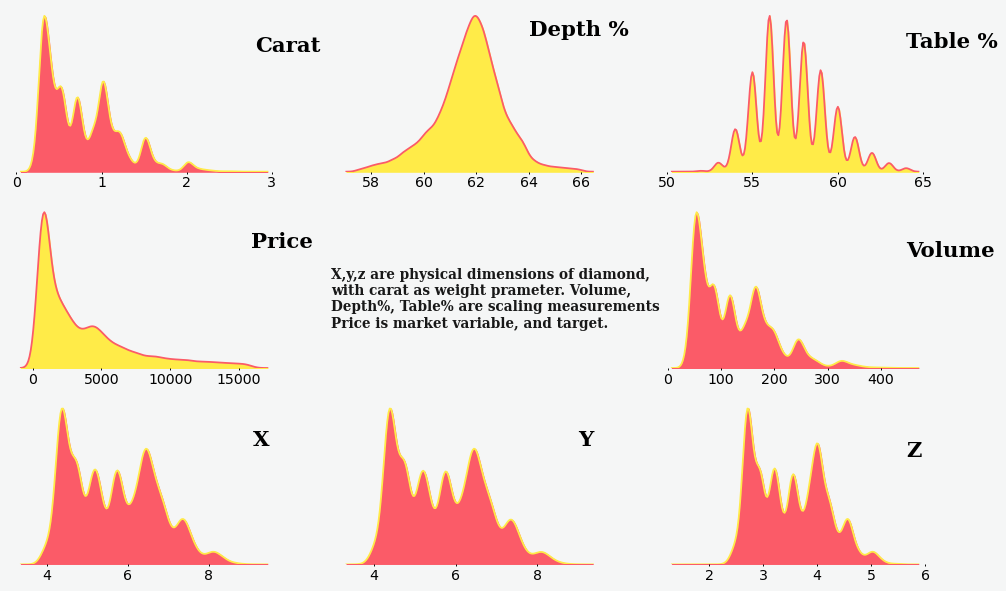

In [26]:
### univariate ananalysis


fig =  plt.figure(figsize = (14,8.5), dpi = 85)
fig.patch.set_facecolor('#f5f6f6')


                                                    ##### Note to reader I could have used subplots feature, but going with grid
                                                           #spec for more controlover plots
gs = fig.add_gridspec(3,3)
gs.update(wspace =0.2,hspace = 0.2)


ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])


ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])



axes = [ax0,ax1,ax2,ax3, ax4,ax5,ax6,ax7,ax8]


for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.tick_params(axis='x',
                   labelsize = 12, which = 'major',
                   direction = 'out',pad = 2,
                   length = 1.5)
    ax.tick_params(axis='y', colors= 'black')
    ax.axes.get_yaxis().set_visible(False)

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

cols = df.select_dtypes(exclude = 'object').columns

### ax0- carat

sns.kdeplot(x = df[cols[0]],fill = True, color = colors[0], alpha = 1, ax = ax0)
sns.kdeplot(x = df[cols[0]],color = colors[1], alpha = 1, ax = ax0)
ax0.set_xlabel(xlabel = '')
ax0.text((df[cols[0]].max() ), 1.4,'Carat', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)





### ax1 - depth
sns.kdeplot(x = df[cols[1]], color = colors[0], alpha = 1, ax = ax1)
sns.kdeplot(x = df[cols[1]], fill = True, color = colors[1], alpha = 1, ax = ax1)
ax1.set_xlabel(xlabel = '')
ax1.text((df[cols[1]].max()-2 ), 0.35,'Depth %', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)




### ax2 -- table
sns.kdeplot(x = df[cols[2]],color = colors[0], alpha = 1, ax = ax2)
sns.kdeplot(x = df[cols[2]], fill = True, color = colors[1], alpha = 1, ax = ax2)

ax2.set_xlabel(xlabel = '')
ax2.text((df[cols[2]].max()), 0.25,'Table %', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)




### ax3 --- price
sns.kdeplot(x = df[cols[3]],  color = colors[0], alpha = 1, ax = ax3)
sns.kdeplot(x = df[cols[3]], fill = True, color = colors[1], alpha = 1, ax = ax3)
ax3.set_xlabel(xlabel = '')
ax3.text((df[cols[3]].max()), 0.00025,'Price', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)





### ax4 --- free space

ax4.axes.get_xaxis().set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.text(-0.01,0.25,'X,y,z are physical dimensions of diamond, \nwith carat as weight prameter. Volume, \nDepth%, Table% are scaling measurements. \nPrice is market variable, and target.',
           **{'font':'serif', 'size':11.5,'weight':'bold'}, alpha = 0.9 )


### ax5 --- Volume
sns.kdeplot(x = df[cols[7]], fill = True, color = colors[0], alpha = 1, ax = ax5)
sns.kdeplot(x = df[cols[7]],  color = colors[1], alpha = 1, ax = ax5)
ax5.set_xlabel(xlabel = '')
ax5.text((df[cols[7]].max()), 0.008,'Volume', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)


### ax6 ---- X
sns.kdeplot(x = df[cols[4]], fill = True, color = colors[0], alpha = 1, ax = ax6)
sns.kdeplot(x = df[cols[4]], color = colors[1], alpha = 1, ax = ax6)
ax6.set_xlabel(xlabel = '')
ax6.text((df[cols[4]].max()), 0.4,'X', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)



### ax7 --- Y
sns.kdeplot(x = df[cols[5]], fill = True, color = colors[0], alpha = 1, ax = ax7)
sns.kdeplot(x = df[cols[5]], color = colors[1], alpha = 1, ax = ax7)
ax7.set_xlabel(xlabel = '')
ax7.text((df[cols[5]].max() ), 0.4,'Y', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)




### ax8 ---- z
sns.kdeplot(x = df[cols[6]], fill = True, color = colors[0], alpha = 1, ax = ax8)
sns.kdeplot(x = df[cols[6]],  color = colors[1], alpha = 1, ax = ax8)
ax8.set_xlabel(xlabel = '')
ax8.text((df[cols[6]].max()), 0.6,'Z', **{'font':'serif', 'size':18,'weight':'bold'}, alpha = 1)

ax8.text(5.,-0.25,'',{'font':'serif', 'size':12, 'weight':'bold',},alpha = 0.8)


fig.text(0.07,0.95,'' ,**{'font':'serif', 'size':25,'weight':'bold',}, alpha = 0.9)

fig.text(0.07,0.88,'' ,**{'font':'serif', 'size':12,}, alpha = 0.9)


fig.show()


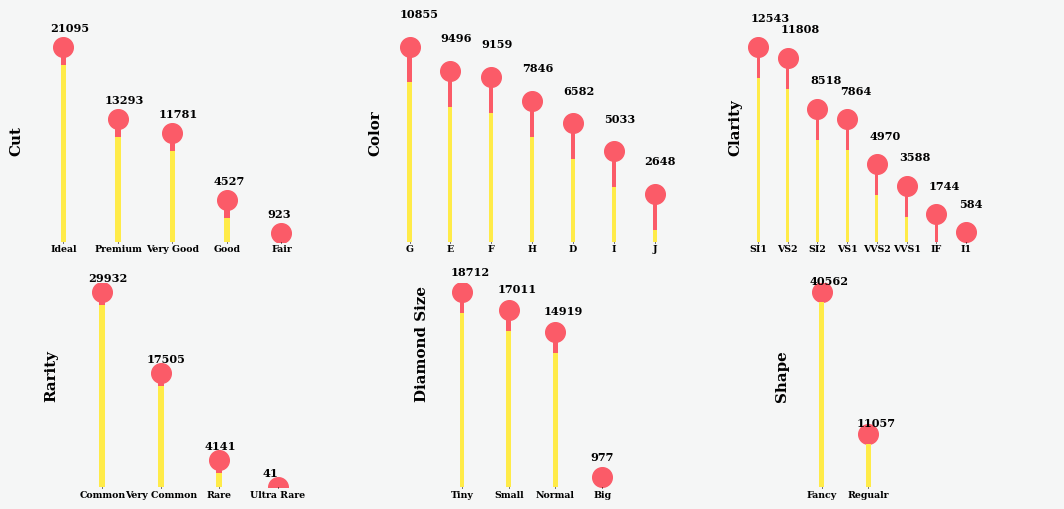

In [29]:
### univariate ananalysis


fig =  plt.figure(figsize = (15,6.5), dpi = 90)
fig.patch.set_facecolor('#f5f6f6')


                                                    ##### Note to reader I could have used subplots feature, but going with grid
                                                           #spec for more controlover plots
gs = fig.add_gridspec(2,3)
gs.update(wspace =0.1,hspace = 0.2)


ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])




axes = [ax0,ax1,ax2,ax3, ax4,ax5,]


for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.tick_params(axis='x',
                   labelsize = 1, which = 'major',
                   direction = 'out',pad = 2,
                   length = 1)
    ax.tick_params(axis='y', colors= 'black')
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(True)

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

cols = df.select_dtypes(exclude = ['int64','float64','float']).columns
labels = ['Cut', 'Color', 'Clarity', 'Rarity', 'Diamond Size', 'Shape']



### ax0- carat
s = 250

for col,ax,label in zip(cols,axes,labels):
    ax.bar(x = df[col].value_counts().index, height = df[col].value_counts().values, width = 0.1, color = colors[0] )
    ax.scatter(x = df[col].value_counts().index, y = df[col].value_counts().values, s = s,color = colors[0] )
    ht = df[col].value_counts().values.max()
    ax.text(-1,ht/2.2 ,label,**{'font':'serif', 'size':12, 'weight':'bold', 'rotation' : 'vertical'}, alpha = 1)
    ax.set_xticklabels(df[col].value_counts().index , rotation = 0,**{'font':'serif', 'size':7.5, 'weight':'bold'}, alpha = 1)

    for pa in ax.patches:
        ax.text((pa.get_x() - 2*pa.get_width() ), pa.get_height()+1600, pa.get_height(), **{'font':'serif', 'size':9, 'weight':'bold',}, alpha = 1)
    height = [ val - 2000 if (val - 2000) > 0 else 0 for val in df[col].value_counts().values ]
    ax.bar(x = df[col].value_counts().index, height = height , width = 0.1, color = colors[1] )




fig.text(0.09,1.06,'' ,**{'font':'serif', 'size':18,'weight':'bold', }, alpha = 1)

fig.text(0.09,0.97,'''''' ,**{'font':'serif', 'size':12,'weight':'normal',}, alpha = 0.75)


ax0.set_xlim(-1,5)
ax1.set_xlim(-1,7)
ax2.set_xlim(-1,10)
ax3.set_xlim(-1.6,4)
ax4.set_xlim(-2,5)
ax5.set_xlim(-2,5)


fig.text(0.75,0.075,'',{'font':'serif', 'size':9, 'weight':'bold',},alpha = 0.75)

fig.show()


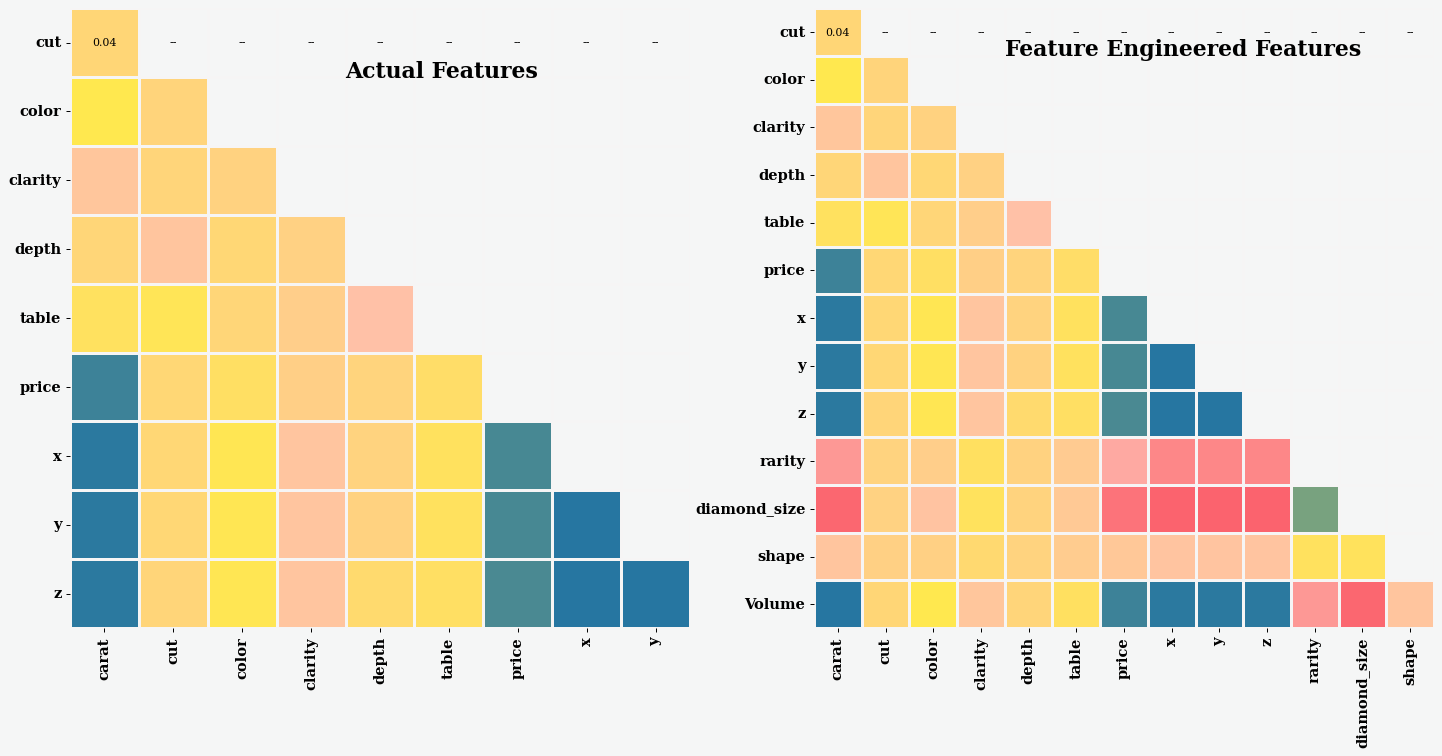

In [33]:
actualdf = df_backup.copy()

featdf = df.copy()

for col in actualdf.select_dtypes(exclude = ['int','float','float64','int64']).columns:
    le = LabelEncoder()
    actualdf[col] = le.fit_transform(actualdf[col])

for col in featdf.select_dtypes(exclude = ['int','float','float64','int64']).columns:
    le = LabelEncoder()
    featdf[col] = le.fit_transform(featdf[col])




## actual correlations
act_corr = actualdf.corr()
mask1 = np.triu(np.ones_like(act_corr, dtype=bool))
mask1 = mask1[1:, :-1]
act_corr = act_corr.iloc[1:,:-1].copy()

## featured correlations
fea_corr = featdf.corr()
mask2 = np.triu(np.ones_like(fea_corr, dtype=bool))
mask2 = mask2[1:, :-1]
fea_corr = fea_corr.iloc[1:,:-1].copy()

cust_colors = ['#FB5B68','#FFBDB0','#FFEB48','#2676A1',]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("",cust_colors)

fig, ax = plt.subplots(1,2, figsize = (20,10), dpi = 88)
fig.patch.set_facecolor('#f5f6f6')

axes = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')


### actual heatmap
sns.heatmap(data = act_corr, ax = axes[0], vmin= -1,vmax = 1 ,
            annot = True, fmt = '1.0g', annot_kws={'font':'serif', 'size':9, 'weight':'normal', 'color':'black'},
            square = True, linewidth = 1, linecolor = '#f6f5f5',
             cmap = colormap, mask = mask1, cbar = False,alpha = 1)


### featured heatmap
sns.heatmap(data = fea_corr, ax = axes[1], vmin = -1, vmax = 1,
            annot = True, fmt = '1.0g',annot_kws={'font':'serif', 'size':9, 'weight':'normal', 'color':'black'},
            square = True, linewidth = 1, linecolor = '#f6f5f5',
             cmap = colormap, mask = mask2, cbar = False, alpha = 1)


for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation =90,**{'font':'serif', 'size':12, 'weight':'bold', 'color':'black'})
    ax.set_yticklabels(ax.get_yticklabels(), rotation =0,**{'font':'serif', 'size':12, 'weight':'bold', 'color':'black'})


axes[0].text(4, 1, 'Actual Features',{'font':'serif', 'size':18, 'weight':'bold', 'color':'black'})
axes[1].text(4,1, 'Feature Engineered Features',{'font':'serif', 'size':18, 'weight':'bold', 'color':'black'})


fig.text(0.095,0.965, '',{'font':'serif', 'size':20, 'weight':'bold', 'color':'black'})
fig.text(0.095,0.88, '''''',{'font':'serif', 'size':14, 'weight':'normal', 'color':'black'})


fig.text(0.7,0.01,'',{'font':'serif', 'size':9, 'weight':'bold','color':'black'},alpha = 0.75)


fig.show()

In [34]:
def custom_scatter(x,y,value, size = None,figsize = None, ax = None, marker = None, color = None):

    x_labels = [val for val in sorted(x.unique())]
    y_labels  = [val for val in sorted(y.unique())]

    x_to_num = {val:idx for idx,val in enumerate(x_labels)}
    y_to_num = {val:idx for idx,val in enumerate(y_labels)}


    x_values = x.map(x_to_num)
    y_values = y.map(y_to_num)


    if size == None:
        size = 1
    if ax == None:
        fig,ax = plt.subplots(figsize = figsize)
    if marker == None:
        marker = None
    else:
        marker = marker

    ax.scatter(x = x_values,y = y_values, s = value * size, c = color, marker = marker)


    ax.set_xticks(ticks = x_values.unique())
    ax.set_yticks(ticks = y_values.unique())

    ax.set_xticklabels(labels = x_labels,**{'font':'serif', 'size':12,'weight':'bold'}, alpha = 1)
    ax.set_yticklabels(labels = y_labels,**{'font':'serif', 'size':12,'weight':'bold'}, alpha = 1)

    ax.set_xlim(x_values.min()-0.5, x_values.max()+0.5)
    ax.set_ylim(y_values.min()-0.5, y_values.max()+0.5)



    ax.grid(False, 'major')

    ax.grid(False, 'minor', )
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)


    #ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    #ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    return None

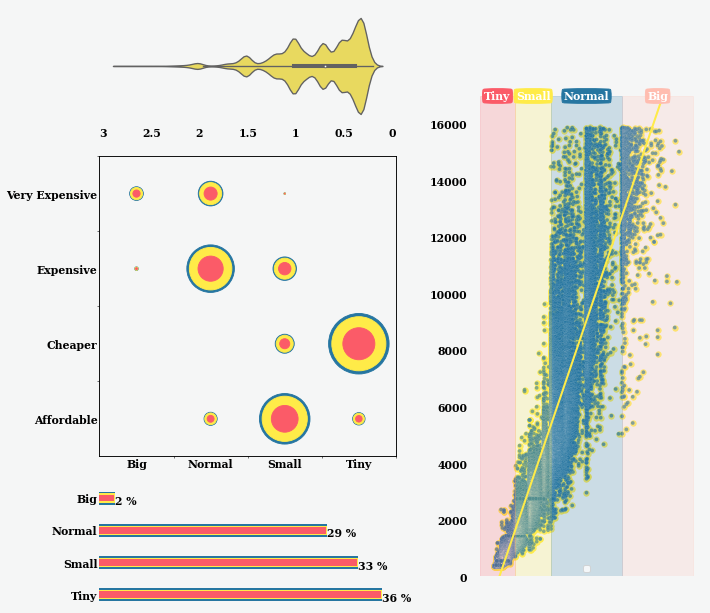

In [37]:

tem = df.copy()
tem['price_cat'] = pd.cut(df['price'], bins = [0,1500,4000,10000,100000], labels = ['Cheaper','Affordable', 'Expensive', 'Very Expensive'])
tem['price_cat'] = tem['price_cat'].astype('object')


tab = pd.crosstab(tem['diamond_size'],tem['price_cat'])
tab_val = pd.melt(tab.reset_index(),id_vars = 'diamond_size')
tab_val.columns = ['x','y','value']


fig = plt.figure(figsize = (12,12), dpi = 65)
fig.patch.set_facecolor('#f5f6f6')
gs = fig.add_gridspec(20,20)
gs.update(wspace = 0.6, hspace = 0)

ax0 = fig.add_subplot(gs[0:,0:])
ax0.set_facecolor('#f5f6f6')
ax0.axes.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(False)
for loc in ['left', 'right', 'top', 'bottom']:
        ax0.spines[loc].set_visible(False)



ax1 = fig.add_subplot(gs[0:4,0:10])

ax2 = fig.add_subplot(gs[3:19,12:20])

ax3 = fig.add_subplot(gs[5:15,0:10])

ax4 = fig.add_subplot(gs[16:20,0:10])

axes = [ax1,ax2,ax3,ax4]

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.tick_params(axis='both',
                   labelsize = 12, which = 'major',
                   direction = 'out',pad = 2,
                   length = 0.001)

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_linewidth(1)


##############################################violin plot
sns.violinplot(x = -df['carat'],  ax = ax1, color = colors[1], alpha = 1, linecolor = 'black')


## violin
ticks = [3.5,3,2.5,2,1.5,1,0.5,0]
ax1.set_xticklabels(labels = ticks, **{'font':'serif','size':12, 'weight':'bold'},alpha = 1)
ax1.set_xlabel('')
for loc in ['left', 'right', 'top', 'bottom']:
    ax1.spines[loc].set_visible(False)


############################################### scatter plot and regplot
sns.regplot(x = 'carat', y = 'price',data = tem, ax = ax2, color = colors[1],)
sns.scatterplot(x = 'carat', y = 'price',data = tem, ax = ax2, alpha = 0.7,size = 0.5, color = colors[2],**{'linewidth' : 0.1})

ax2.legend(labels = [])

ax2.set_yticklabels(np.arange(0,18000,2000),**{'font':'serif','size':12, 'weight':'bold'},alpha = 1)
ax2.set_xticklabels('')
ax2.set_ylabel('')
ax2.set_xlabel('')
for loc in ['left', 'right', 'top', 'bottom']:
    ax2.spines[loc].set_visible(False)


## generating spans for diamond sizes
## www.kaggle.com/subinium/simple-matplotlib-visualization-tips/  --- #thanks to @subinium

bin_labels = ['Tiny','Small','Normal','Big']
size_bins = [[0, 0.5], [0.5,  1], [1, 2], [2, 3]]

for idx, label in enumerate(bin_labels):
        ax2.annotate(label,
                    xy=(sum(size_bins[idx])/2 ,17000),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    **{'font':'serif','size':12, 'weight':'bold','color':'white'},
                    bbox=dict(boxstyle='round4', pad=0.2, color=colors[idx], alpha=1))
        ## adding span over region
        ax2.axvspan(size_bins[idx][0],size_bins[idx][1], ymax = 1, color=colors[idx], alpha=0.2)

ax2.set_ylim(0,17000)

####################################################### scattermap
custom_scatter(x = tab_val['x'], y = tab_val['y'], value = tab_val['value'], size = 0.25, ax = ax3, color = colors[2])
custom_scatter(x = tab_val['x'], y = tab_val['y'], value = tab_val['value'], size = 0.2, ax = ax3, color = colors[1])
custom_scatter(x = tab_val['x'], y = tab_val['y'], value = tab_val['value'], size = 0.07, ax = ax3, color = colors[0])
ax3.set_facecolor('#f5f6f6')


##################################################### final ratio plot
dia_size = round(tem.diamond_size.value_counts(normalize = True) * 100,0).astype(int)

ax4.barh(y = dia_size.index, width = dia_size.values, height = 0.4, color = colors[2])



for pa in ax4.patches:
        ax4.text((pa.get_width()), pa.get_y(),'{} %'.format(pa.get_width()), **{'font':'serif', 'size':12, 'weight':'bold'}, alpha = 1)

ax4.barh(y = dia_size.index, width = dia_size.values, height = 0.3, color = colors[1])
ax4.set_yticklabels(labels = dia_size.index,**{'font':'serif', 'size':12,'weight':'bold'}, alpha = 1)



ax4.barh(y = dia_size.index, width = dia_size.values -00.1, height = 0.2, color = colors[0])
for loc in ['left', 'right', 'top', 'bottom']:
    ax4.spines[loc].set_visible(False)
ax4.axes.get_xaxis().set_visible(False)




### titles and descriptions

fig.text(0,0.98, '',{'font':'serif', 'size':20.,'weight':'bold'}, alpha = 1)


fig.text(0,0.92,'''''',{'font':'serif', 'size':11,'weight':'normal'}, alpha = 0.8)


fig.text(0.05, 0.88, '',{'font':'serif', 'size':16,'weight':'bold'}, alpha = 0.9)


fig.text(0.55, 0.88, '',{'font':'serif', 'size':16,'weight':'bold'}, alpha = 0.9)

fig.text(0.75,0.1,'',{'font':'serif', 'size':10, 'weight':'bold'},alpha = 0.75)
fig.show()

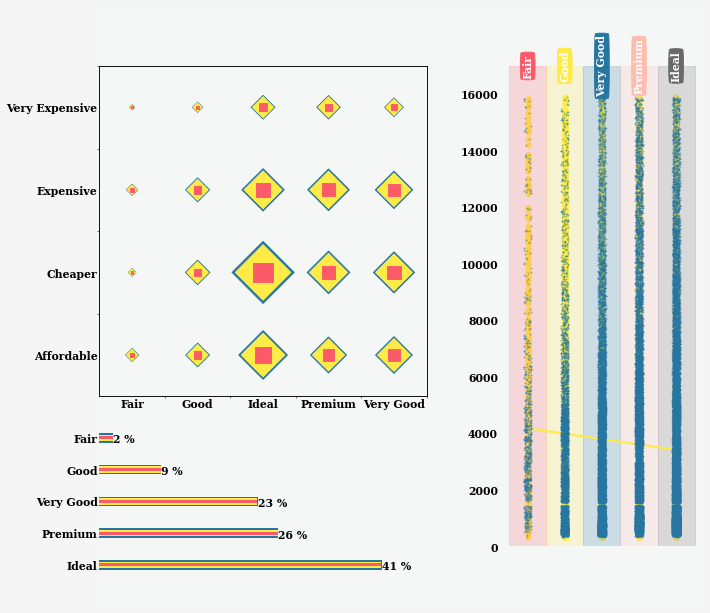

In [40]:
tem = df.copy()
tem['price_cat'] = pd.cut(df['price'], bins = [0,1500,4000,10000,100000], labels = ['Cheaper','Affordable', 'Expensive', 'Very Expensive'])
tem['price_cat'] = tem['price_cat'].astype('object')


tab = pd.crosstab(tem['cut'],tem['price_cat'])
tab_val = pd.melt(tab.reset_index(),id_vars = 'cut')
tab_val.columns = ['x','y','value']

cut_labels = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
cut_to_num = { val : idx for idx,val in enumerate(cut_labels)}

tem['cut'] = tem['cut'].map(cut_to_num)


fig = plt.figure(figsize = (12,12), dpi = 65)
fig.patch.set_facecolor('#f6f5f5')
gs = fig.add_gridspec(20,20)
gs.update(wspace = 0.6, hspace = 0)

ax0 = fig.add_subplot(gs[0:,0:])
ax0.set_facecolor('#f5f6f6')
ax0.axes.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(False)
for loc in ['left', 'right', 'top', 'bottom']:
        ax0.spines[loc].set_visible(False)


#ax1 = fig.add_subplot(gs[0:4,0:10])

ax2 = fig.add_subplot(gs[2:18,13:20])

ax3 = fig.add_subplot(gs[2:13,0:11])

ax4 = fig.add_subplot(gs[14:19,0:10])

axes = [ax1,ax2,ax3,ax4]

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.tick_params(axis='both',
                   labelsize = 12, which = 'major',
                   direction = 'out',pad = 2,
                   length = 0.001)

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_linewidth(1)




############################################### scatter plot and regplot
sns.regplot(x = 'cut', y = 'price',data = tem, ax = ax2, color = colors[1])
sns.stripplot(x = 'cut', y = 'price',data = tem, ax = ax2, alpha = 0.5, color = colors[2], size = 2)
ax2.set_yticklabels(np.arange(0,18000,2000),**{'font':'serif','size':12, 'weight':'bold'},alpha = 1)
ax2.set_xticklabels('')
ax2.set_ylabel('')
ax2.set_xlabel('')
for loc in ['left', 'right', 'top', 'bottom']:
    ax2.spines[loc].set_visible(False)


bin_labels = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
size_bins = [[-0.5,0.5],[0.5, 1.5], [1.5,  2.5], [2.5, 3.5], [3.5, 4.5]]

col_here = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0','dimgrey']
for idx, label in enumerate(bin_labels):
        ax2.annotate(label,
                    xy=(sum(size_bins[idx])/2 ,17000),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",rotation = 90,
                    **{'font':'serif','size':12, 'weight':'bold','color':'white'},
                    bbox=dict(boxstyle='round4', pad=0.2, color=col_here[idx], alpha=1))
        ## adding span over region
        ax2.axvspan(size_bins[idx][0],size_bins[idx][1], ymax = 1, color=col_here[idx], alpha=0.2)

ax2.set_ylim(0,17000)


####################################################### scattermap

custom_scatter(x = tab_val['x'], y = tab_val['y'], value = tab_val['value'], marker = 'D',size = 0.25, ax = ax3, color = colors[2])
custom_scatter(x = tab_val['x'], y = tab_val['y'], value = tab_val['value'], marker = 'D',size = 0.2, ax = ax3, color = colors[1])
custom_scatter(x = tab_val['x'], y = tab_val['y'], value = tab_val['value'], marker = 's',size = 0.05,ax = ax3, color = colors[0])
ax3.set_facecolor('#f5f6f6')


##################################################### final ratio plot

cut = round(df.cut.value_counts(normalize = True) * 100,0).astype(int)

ax4.barh(y = cut.index, width = cut.values, height = 0.3, color = colors[2])



for pa in ax4.patches:
        ax4.text((pa.get_width()), pa.get_y(),'{} %'.format(pa.get_width()), **{'font':'serif', 'size':12, 'weight':'bold'}, alpha = 1)

ax4.set_yticklabels(labels = cut.index,**{'font':'serif', 'size':12,'weight':'bold'}, alpha = 1)


ax4.barh(y = cut.index, width = cut.values -00.1, height = 0.2, color = colors[1])
ax4.barh(y = cut.index, width = cut.values -00.1, height = 0.1, color = colors[0])
for loc in ['left', 'right', 'top', 'bottom']:
    ax4.spines[loc].set_visible(False)
ax4.axes.get_xaxis().set_visible(False)




### titles and descriptions

fig.text(0,0.98, '',{'font':'serif', 'size':20.,'weight':'bold'}, alpha = 1)

fig.text(0,0.92,'''''',{'font':'serif', 'size':12,'weight':'normal'}, alpha = 0.9)


fig.text(0.05, 0.88, '',{'font':'serif', 'size':16,'weight':'bold'}, alpha = 1)

fig.text(0.55, 0.88, '',{'font':'serif', 'size':16,'weight':'bold'}, alpha = 1)

fig.text(0.552, 0.85, '',{'font':'serif', 'size':12,'weight':'normal'}, alpha = 0.9)

fig.text(0.75,0.1,'',{'font':'serif', 'size':10, 'weight':'bold'},alpha = 0.75)
fig.show()

In [41]:
!pip uninstall umap -y
!pip install umap-learn
from umap.umap_ import UMAP


Defaulting to user installation because normal site-packages is not writeable
Using legacy 'setup.py install' for umap-learn, since package 'wheel' is not installed.
Using legacy 'setup.py install' for pynndescent, since package 'wheel' is not installed.
    Running setup.py install for pynndescent: started
    Running setup.py install for pynndescent: finished with status 'done'
    Running setup.py install for umap-learn: started
    Running setup.py install for umap-learn: finished with status 'done'


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [42]:
print('final preprocessing of variables......')
#log transform to all the variables to make less skewed
featdf["price"] = np.log1p(featdf["price"])

#log transform skewed numeric features:
numeric_feats = featdf.dtypes[featdf.dtypes != "object"].index

skewed_feats = featdf[numeric_feats].dropna().skew() #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

featdf[skewed_feats] = np.log1p(featdf[skewed_feats])

# split data into X and y
X = featdf.drop(columns = ['price'])
y = featdf['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 2021)

#X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.1, random_state = 2021)

print('All set! Good to go!')

final preprocessing of variables......
All set! Good to go!


<br>
<br>
<div style = "font-family: serif; font-size: 18px; font-weight:;">
Every feature cannot be of same importance in prediction as most of the data includes of redundant data with in. Moreover an effective prunnin of data, could save lots of trianing time as well. So, to know which feature is to keep in the dataset, lets explolit the inbuilt functionality of the XGBoost regressors feature importance. Few helper functions are defined below to met the objective. </div>

In [43]:
def feature_importance(X_val, y_val, importance=None):
    if importance is None:
        importance = 'weight'
    else:
        importance = importance

    model = XGBRegressor(random_state=2021)
    model.fit(X_val, y_val)
    imp = model.get_booster().get_score(importance_type=importance)
    imp_results = (pd.DataFrame({'Features': imp.keys(), 'Importance': imp.values()})
            .sort_values(by='Importance'))
    return imp_results

def plot_imp(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor(colors[2])
        ax.set_facecolor(colors[2])

        ax.tick_params(axis='both',
                       labelsize=12, which='major',
                       direction='out', pad=2,
                       length=0.0001)

    data['shades'] = data['Features'].apply(lambda x: '#FB5B68' if x == 'Random' else colors[1])

    ax.barh(y=data.Features, width=data.Importance,
            height=0.5, color=data['shades'])

    for loc in ['left', 'right', 'bottom', 'top']:
        ax.spines[loc].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.set_yticklabels(data.Features)  # Removed additional arguments




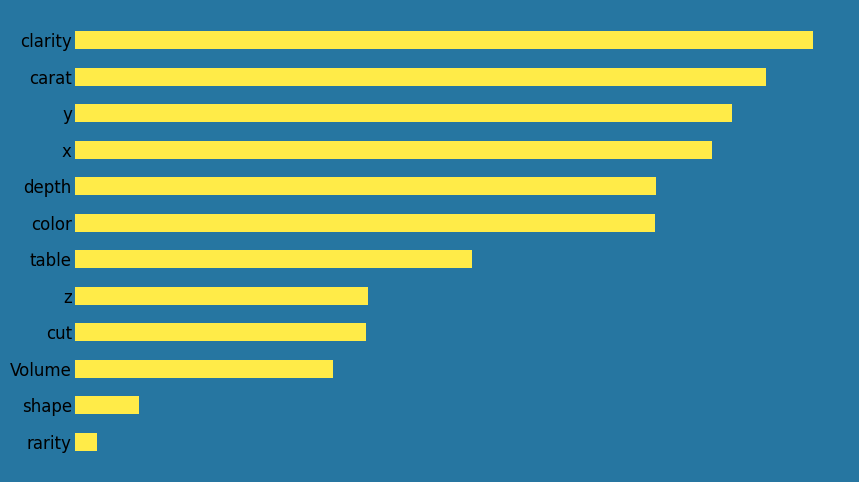

In [45]:
plot_imp(feature_importance(X_train,y_train))
plt.show()

<br>
<br>
<div style = "font-family: serif; font-size: 18px; font-weight:;"> Though feature importance showing expected features on top of the list, its better to perform a random feature test to eliminate the doubt of randomness in the system.</div><br><br>

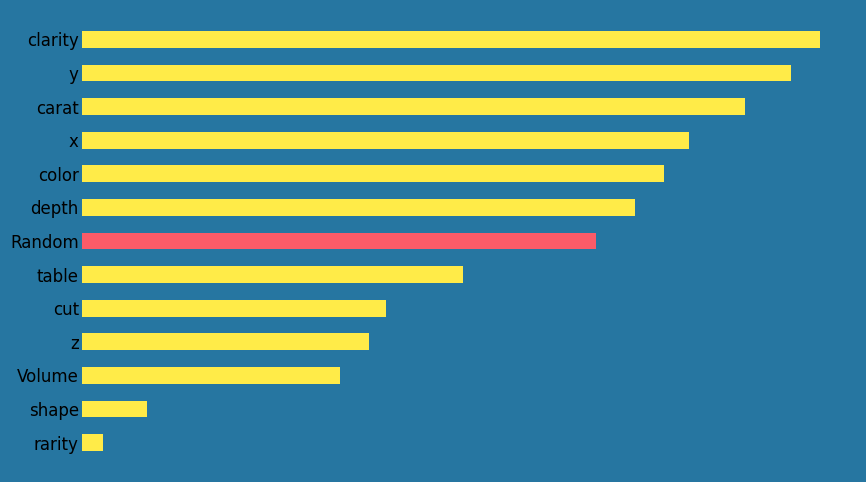

In [47]:
X_train_rand = X_train.copy()
X_train_rand['Random'] = np.random.random(size=len(X_train_rand))
plot_imp(feature_importance(X_train_rand,y_train))
plt.show()

<br>
<br>
<div style = "font-family: serif; font-size: 18px; font-weight:;"> With introduction of a random feature into the training data, is  shows very interesting results. Our randomized feature is outperforming the actal features, and this may be valid but, now raise the doubt out trust worthyness of our features for random act. To over come this doubt, lets perfom a permutation feature importance and decide which feature is matter. </div><br>

<br>
<br>
<div style = "font-family: serif; font-size: 18px; font-weight:;">
premutaion importance ensures to keep only real impacting features in the training data.
    
we shuffle internally one feature at a time and measure its impact on the given metric and we rank the features according to residue of metric loss. </div>

<br>
<br>

<br>
<br>
<div style = "font-family: serif; font-size: 18px; font-weight:;"> Lets code an simple permutaion feature selection helper.
Idea behind is discussed in an article named Beware of Random Forests, and here we will see which feature is actually important by measureing the change in metric with randomization of the one feature at a time.
<br>
<br>
<ul> Its a four step process and it goes as follows.<br>
    <br>
    <li> Split the training data into training data,and hold on data(validataion data).</li><br>
    <li> Fit the model with training data, and get a baseline metric with validation data.</li><br>
    <li> Key part is shuffle one feature at time in validation case and find the metric with shuffle validaiton data on pretrained model.</li><br>
    <li> For each modified metric calculte the residual between baseline metric and modified metric</li><br>
    <li> Highly important feature could result in higher in residual, which imploys its importance</li><br>
    
</ul>
<br>

</div>

In [48]:
### permutation importance do not retrain over all the features.


def Permutation_importances(feat,targ):

    ## spliting data into validation set or hold out for generality of the importances
    X_train,X_val,y_train,y_val = train_test_split(feat,targ, test_size = 0.2, random_state = 2021)


    model = XGBRegressor()
    model.fit(X_train,y_train)
    ypreds = model.predict(X_val)
    baseline_r2 = r2_score(y_val,ypreds)

    imp = []

    for col in X_val.columns:
        save = X_val[col].copy()
        X_val[col] = np.random.permutation(X_val[col])   ## Making a random feature by fixing all other feature undisturbed
        rand_ypreds = model.predict(X_val)
        rand_r2    = r2_score(y_val,rand_ypreds)

        X_val[col] = save

        imp.append(baseline_r2 - rand_r2)
    results =  (pd.DataFrame({'Features':X_val.columns, 'Importance':imp})
                .sort_values(by = 'Importance'))
    #results['Featrue_ranking'] = [(len(X_val.columns) - idx) for idx,val in enumerate(results['Importance'])]
    return results

In [49]:
per_imp = Permutation_importances(X_train,y_train)

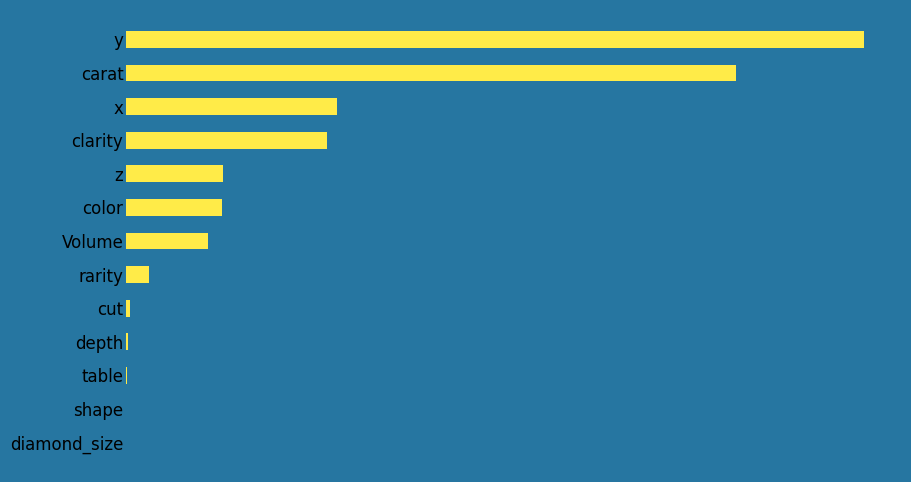

In [51]:
plot_imp(per_imp)

plt.show()

<div style = "font-family: serif; font-size: 18px; font-weight:;"> Implementing Premutation Importance for El5 module to validate our litte experiment with premutation importance. Weights of each feature importance shows the similar trend as our experiment, and thus corroborating that our method is valid as eli5 implementation. For feature selection lets use these importances. <br><br> </div>

In [52]:
np.random.seed(2021)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 2021)

model = XGBRegressor().fit(X_train,y_train)


perm = PermutationImportance(model,scoring='r2' ).fit(X_val,y_val)
eli5_feature_importance = (pd.DataFrame({'Features':X_train.columns.tolist(),'Importance':perm.feature_importances_})
                           .sort_values(by = 'Importance'))

print('Feature impact weights and importance for the given model:')
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

NameError: name 'PermutationImportance' is not defined

<div style = "font-family: serif; font-size: 18px; font-weight:;"> Comparision of the Naive implementation and eli5 implementation. </div>

NameError: name 'eli5_feature_importance' is not defined

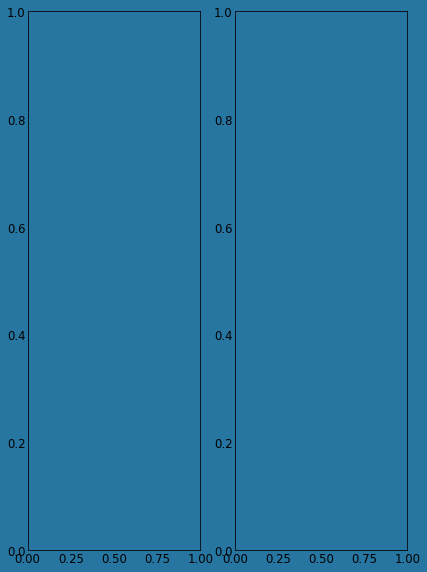

In [53]:
fig, ax = plt.subplots(1,2, figsize = (7,10), dpi = 70)
fig.patch.set_facecolor(colors[2])

axes = ax.ravel()

for ax in axes:
    ax.set_facecolor(colors[2])
    ax.tick_params(axis='both',
                   labelsize = 12, which = 'major',
                   direction = 'out',pad = 2,
                   length = 0.0001)

plot_imp(eli5_feature_importance, ax = axes[0])
plot_imp(per_imp, ax = axes[1])
plt.gcf().text(-0.35,0.95,'Diamonds and Dollors: Naive Implementation VS Eli5 Permutation Importance',{'font': 'serif', 'size':18,'weight':'bold','color':'white'})
plt.gcf().text(-0.35, 0.91,'''With a simple algoritham, we got out permuated feature importances from our naive implementation
But Question is are the accurate? To see that we implement Permutation Importance from well know Eli5.'''
               ,{'font': 'serif', 'size':12,'weight':'normal','color':'white'}, alpha = 1)
plt.gcf().text(0.25, 0.88,'Naive',{'font': 'serif', 'size':15,'weight':'bold','color':'white'}, alpha = 1)
plt.gcf().text(0.7, 0.88,'Eli5',{'font': 'serif', 'size':15,'weight':'bold','color':'white'}, alpha = 1)
plt.gcf().text(0.86,0.15,'© Made by bhuvanchennoju/Kaggle',{'font':'serif', 'size':8, 'weight':'bold','color':'white'},alpha = 0.8)
plt.show()

<br><br>
<a id = '5.2'></a>
<h2 style = "font-family: Garamond; font-size:35px; font-weight: bold; border-radius: 300px 300px; background-color: #2676A1; color : #FFEB48; padding:2px" align = 'center'> 5.2 Base models and Results </h2>
<a href = '#0' style = 'font-size:15px' align = 'right'>⏫</a>
<a href = '#5.1.3.2' style = 'font-size:15px' align = 'right'>🔼</a>
<a href = '#5.3' style = 'font-size:15px' align = 'right'>🔽</a>
<a href = '#7' style = 'font-size:15px' align = 'right'>⏬</a>
<br><br>

<div style = "font-family: serif; font-size: 18px; font-weight:;"> From the premutation feature selection, selecing top 6 featrues for the modeling. And lets hope this could give the better results.
<br>
<br>
For modeling part few linear models, tree based models, and boosting models are appended to a list of regressors and implementing a crossvalidtion of  10 folds to know the best model.
   <br>
    <br>
</div>

In [54]:
## feature selection based on permutation importance
feature_import = (eli5_feature_importance.sort_values(by = 'Importance', ascending = False)
                  .reset_index(drop = True).Features.tolist()[0:6]) ## selecting top 6 features with help of permutation importance


# split data into X and y
X = featdf.copy().drop(columns = ['price'])
y = featdf['price'].copy()

X_train,X_test,y_train,y_test = train_test_split(X[feature_import],y,test_size = 0.2,random_state = 2021)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


NameError: name 'eli5_feature_importance' is not defined

In [55]:
## appending all the regressors

regressors = []

regressors.append(LinearRegression())
regressors.append(Lasso(alpha = 0.0005,max_iter = 1000))
regressors.append(RandomForestRegressor(n_estimators = 200,max_depth=15))
regressors.append(AdaBoostRegressor())
regressors.append(GradientBoostingRegressor())
regressors.append(XGBRegressor(n_estimators = 200,importance_type = 'gain'))
regressors.append(LGBMRegressor(n_estimators = 200, objective ='regression',
                                importance_type = 'gain'))

In [56]:
import time

print('Working on base models and fitting begains.....')

kfolds = KFold(n_splits = 5, shuffle = False)

baseline_models= clone(regressors)
algo = ['LinearRegression','Lasso', 'RandomForestRegressor' ,'AdaBoostRegressor',
                                          'GradientBoostingRegressor', 'XGBRegressor','LGBMRegressor']

cv_results = list()
for idx, reg in enumerate(baseline_models):
    t = time.time()
    print('Fitting of {} Model'.format(algo[idx]))
    print('Parameters of the model are: {}'. format(reg.get_params()))

    cv_results.append(cross_val_score(estimator=reg,X =X_train,y= y_train, cv = kfolds, n_jobs = -1, scoring= 'r2'))

    print('time elapsed is : {} sec'.format(round((time.time() - t),2)))
    print('\n\n\n*****************************\n\n\n')

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

baseline_cv_res = pd.DataFrame({'CrossValMeans':cv_means,"CrossValerrors":
                      cv_std,"Algorithm":['LinearRegression','Lasso', 'RandomForestRegressor' ,'AdaBoostRegressor',
                                          'GradientBoostingRegressor', 'XGBRegressor','LGBMRegressor']})


Working on base models and fitting begains.....
Fitting of LinearRegression Model
Parameters of the model are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
time elapsed is : 2.3 sec



*****************************



Fitting of Lasso Model
Parameters of the model are: {'alpha': 0.0005, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
time elapsed is : 2.07 sec



*****************************



Fitting of RandomForestRegressor Model
Parameters of the model are: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False

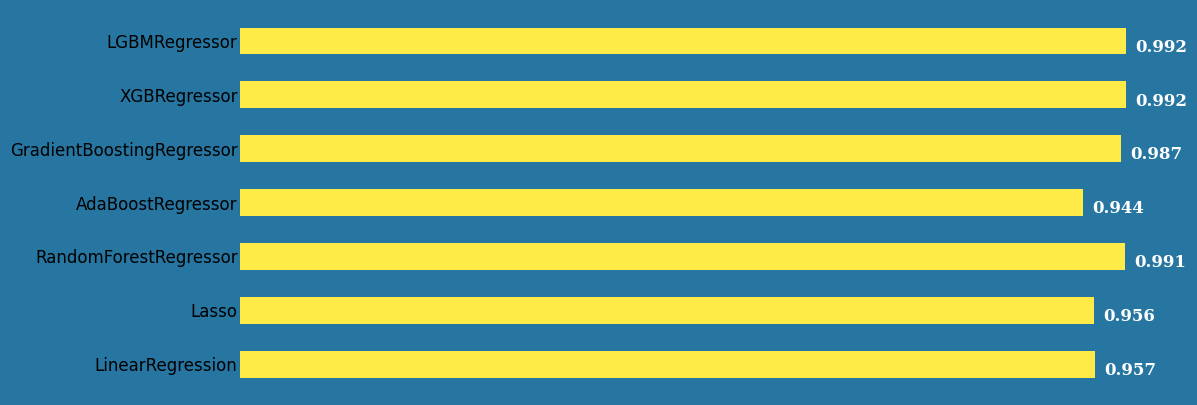

In [58]:
fig,ax = plt.subplots(figsize = (12,5), dpi = 100)
fig.patch.set_facecolor(colors[2])
ax.set_facecolor(colors[2])
ax.tick_params(axis='both',
                   labelsize = 12, which = 'major',
                   direction = 'out',pad = 2,
                   length = 0.001)

ax.barh(y = baseline_cv_res['Algorithm'], width = baseline_cv_res['CrossValMeans'] , height = 0.5,color = colors[1])
ax.set_yticklabels(baseline_cv_res['Algorithm'])

#ax.errorbar(x = , b, xerr=c, fmt="o", color="r")

for pa in ax.patches:
        ax.text((pa.get_width())+0.01, pa.get_y()+0.05,'{}'.format(round(pa.get_width(),3)), **{'font':'serif', 'size':12, 'weight':'bold','color':'white'}, alpha = 1)

ax.axes.get_xaxis().set_visible(False)

for loc in ['left', 'right', 'top','bottom']:
    ax.spines[loc].set_visible(False)


fig.show()

In [59]:
class stackedRegression():
    """ X: features as a dataframe
        Y: target as a dataframe

         methods are
         .fit(X,y) -- fitts on regressor
         .predict(X)  --- final predictions of the model"""

    ## initialization of stackedRegression class with required parameters


    def __init__(self,base_models,meta_model,n_jobs,cv = 5):

        self.base_models = base_models
        self.meta_model = meta_model
        self.cv = cv
        self.n_jobs = n_jobs


    ## defining a fit method for stackedRegression

    def fit(self, X,y):

        ## create an empty list with embedded list to store the model states for all the crossvalidation folds
        ## and models -------    shaped would be like this [[cv * cv - in lower triangular array] * number of models]

        self.base_model_states = [[] for model in self.base_models]

        ## creating a copy of a meta model (last model in the stack, analogous to fully connected layer in cnn)
        self.meta_model_clone = clone(self.meta_model)

        # creating folds
        kfolds = KFold(n_splits = self.cv,shuffle = True, random_state = 2021)

        #### Creating an array of meta features to strore the predictions from all the models and folds of cross validation
        meta_features_ = np.zeros((X.shape[0], len(self.base_models)))


        #looping over the base models to fit on folds and extract fold validation predictions
        for idx_of_model, base_model in enumerate(self.base_models):

            for idx, (train_idx,val_idx) in enumerate(kfolds.split(X,y)):

                fold_X_train, fold_y_train = X.iloc[train_idx], y.iloc[train_idx]
                fold_X_val, fold_y_val     = X.iloc[val_idx], y.iloc[val_idx]

                ## cloning base model to keep actual base models unfit and unmodified state
                cloned_base = clone(base_model)

                cloned_base.fit(fold_X_train,fold_y_train)

                self.base_model_states[idx_of_model].append(cloned_base) ## stroing all the fold states to initially created list
                                                                          ## base model states list embedding


                fold_predictions = cloned_base.predict(fold_X_val)  ## fold predictions = Meta features


                ## storing all the fold predictions to meta_features array
                meta_features_[val_idx,idx_of_model] = fold_predictions

        ## training meta model with meta_features( nothing but fold validation predictions stacked in columns for all base models)
        self.meta_model_clone.fit(meta_features_,y)

        return self ## returning the self to return final fit with inheritance



    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) for base_models in self.base_model_states])
        return self.meta_model_clone.predict(meta_features)

In [60]:
X_train_reframe = pd.DataFrame(X_train, columns = X[feature_import].columns.values)
X_test_reframe = pd.DataFrame(X_test,columns = X[feature_import].columns.values)

stacked = stackedRegression(base_models = regressors ,meta_model = XGBRegressor(),n_jobs =None, cv = 5)


stacked.fit(X = X_train_reframe, y =y_train)
finalpreds = stacked.predict(X_test_reframe)

stacked_r2 = r2_score(y_test, finalpreds)

print('R2 score of the stacked model: {}'.format(stacked_r2))

NameError: name 'feature_import' is not defined

NameError: name 'stacked_r2' is not defined

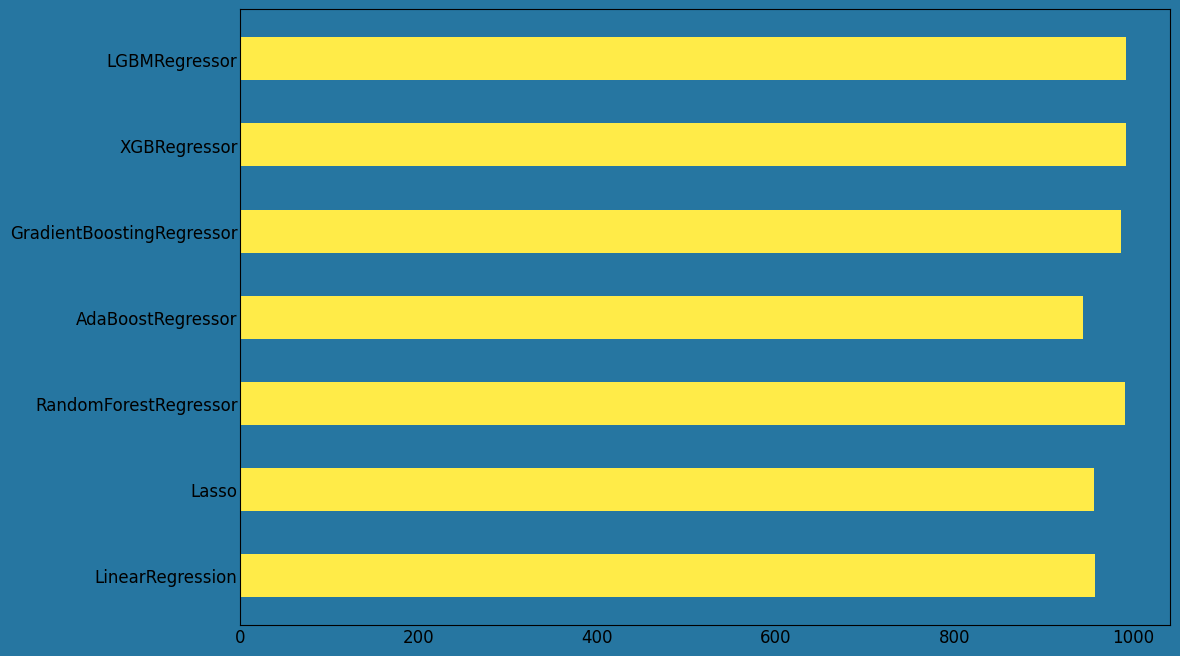

In [61]:
fig,ax = plt.subplots(figsize = (12,8), dpi = 100)
fig.patch.set_facecolor(colors[2])
ax.set_facecolor(colors[2])
ax.tick_params(axis='both',
                   labelsize = 12, which = 'major',
                   direction = 'out',pad = 2,
                   length = 0.001)

ylabels = ['LinearRegression', 'Lasso',
 'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor','Stacked Regressor']

ax.barh(y = baseline_cv_res['Algorithm'], width = baseline_cv_res['CrossValMeans'] *1000, height = 0.5,color = colors[1])
ax.barh(y = 'Stacked Regressor', width = stacked_r2*1000, height = 0.5,color = colors[0])
ax.set_yticklabels(ylabels)

#ax.errorbar(x = , b, xerr=c, fmt="o", color="r")

for pa in ax.patches:
        ax.text((pa.get_width())+0.01, pa.get_y()+0.05,'{}'.format(round(pa.get_width(),3)), **{'font':'serif', 'size':12, 'weight':'bold','color':'white'}, alpha = 1)

ax.axes.get_xaxis().set_visible(False)

for loc in ['left', 'right', 'top','bottom']:
    ax.spines[loc].set_visible(False)

fig.text(-0.15,0.99,'Diamonds and Dollars: Stacked Regression and Baseline models with R2 Score Metric',{'font':'serif','size':24,'weight':'bold', 'color':'white'})
fig.text(-0.15,0.92,''' With implementation of stacking strategy surely gave some improvement in r2 score.
Its pretty decent score for a model with out parameter tuning.''',{'font':'serif','size':16,'weight':'normal', 'color':'white'})
plt.gcf().text(0.85,0.1,'© Made by bhuvanchennoju/Kaggle',{'font':'serif', 'size':8, 'weight':'bold','color':'white'},alpha = 0.8)
fig.show()

<br>
<br>
<div style = "font-family: serif; font-size: 18px; font-weight:;"> From the implementation of the Stacked regressionn surely increased the r2 score a little. May be hyperparemeter tunning of individual base models could change the situation. With optimized parameters may be higher r2 score could be reached. </div>
<br>
<br>

<br>
<br>
<a id = '5.4'></a>
<h2 style = "font-family: Garamond; font-size:35px; font-weight: bold; border-radius: 300px 300px; background-color: #2676A1; color : #FFEB48; padding:2px" align = 'center'> 5.4 Interpretability of Model with Shap Values</h2>
<a href = '#0' style = 'font-size:15px' align = 'right'>⏫</a>
<a href = '#5.3' style = 'font-size:15px' align = 'right'>🔼</a>
<a href = '#6' style = 'font-size:15px' align = 'right'>🔽</a>
<a href = '#7' style = 'font-size:15px' align = 'right'>⏬</a>
<br>
<br>

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X[feature_import], y, test_size = 0.2)

model = XGBRegressor(max_depth=6, random_state=0, n_estimators=200); ### for xgboost no need of scaling
model.fit(X_train, Y_train);
shap_values = shap.Explainer(model).shap_values(X_test)

<div style = "font-family: serif; font-size: 18px; font-weight:;">
Finally, We have our predictions. What next? can we reccomend required diamond to our guy.


Not so fast, though we have our answers, how did we get these answers from our model is still kind of a black art!!

Can we able to unravel the mystery of model and look how each feature impacting the model?, luckily yes. Before trusting our model for sure, lets depend on SHAP Values Concepts. </div>

<div class = "alert alert-block alert-info" "font-family: cursive; font-size: 25px; font-weight:noramal; color:#2676A1 ;border-radius:10px ; background-color: #ffeb48; padding : 15px"><strong> Shap value generaliazation with an example </strong>In layman terms, SHAP Values tell us how much does each feature contributing to reach our final predictions and How they really impact the target prediction. Let me put things clear with an example. Everyone wants to be fit over fat right?, for being fit,
need exercise, healthy diet, good routine, and balanced healthcare. Following them in a right proportions and order could make one fit, and maintaining these in habits in utter commitment could push us towards being fit. On converse, poor commitment proportions of this pull towards
fat. Exactly similar thing SHAP values does, tell us how things impacting our objective, which way are we going in overalll, and which feature is push towards target?, which feature in pulling away from the target?</div>


<div style = "font-family:Garamond; font-size: 25px; font-weight:noramal; color:#2676A1 ;border-radius:5px ; background-color: #ffeb48; padding : 15px">
    Why Model Interpretation is need of the Hour?
<ul>
<li>How much does each feature contributing towards final predictions?</li>
<li>How (positively or negatively) each feature impact the final prediction?</li>
<li>Whats impact of overall features towards final prediction?</li>
</ul>
    This whole questions will be answered with game theory starategy and SHAP values.
</div>
<br><br>

<br><br>
<a id = '5.4.1'></a>
<div style = "font-family: Garamond; font-size: 35px; font-weight:bold; background-color: #2676A1 ; color: #FFEB48 ; padding :5px  ">Gloabal Intepretability of the Model:</div>
<a href = '#0' style = 'font-size:15px' align = 'right'>⏫</a>
<a href = '#5.4' style = 'font-size:15px' align = 'right'>🔼</a>
<a href = '#5.4.2' style = 'font-size:15px' align = 'right'>🔽</a>
<a href = '#7' style = 'font-size:15px' align = 'right'>⏬</a>
<br>
<br>
<br>


<div style = "font-family: serif; font-size: 18px; font-weight:;">With the global interpretability one can get the overall how each feature is effecting the model and prediction. This SHAP values enable us to understand how this complex models work in a a global scale for all features.
<br>
<br>
Here questions, we deal are about the feature contriution with respect to highly interacting feature to the predictions. Global interpretations can be visualized with the help of the dependence plots and scatter plot. What we are interested are like how each feature realted to coressponding SHAP values, and how highly interacting feature effecting this SHAP values.
<br>
<br>
To Answer this question lets examine the predictions of model with xgboost regressor, as it is giving the best score after the stacked regressor. And use SHAP module to find the shap values and visualize the results.


<br><br>
Lets see the one particular features global interpretation with the dependency plot.
<br>
</div>

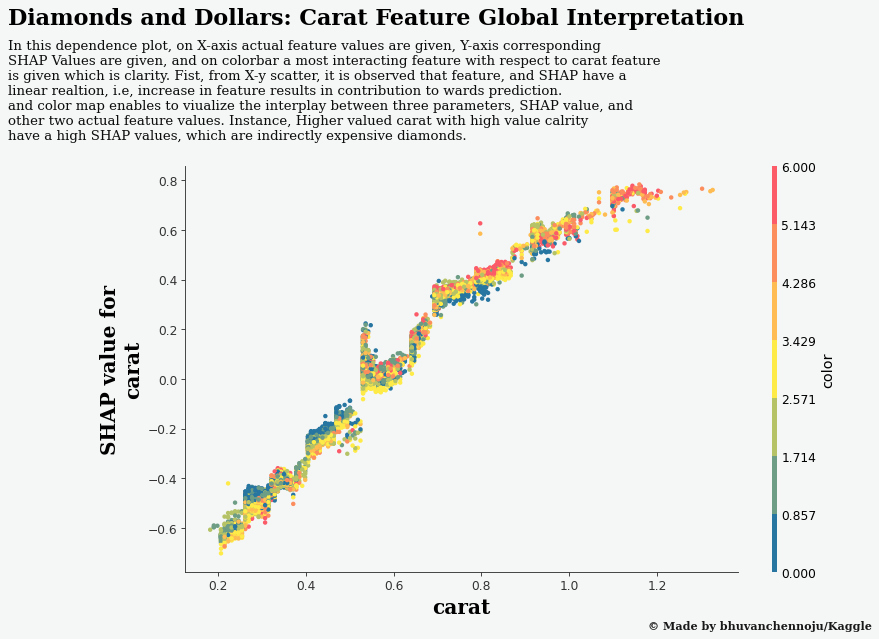

In [ ]:
fig,ax =  plt.subplots(figsize =(10,6), dpi = 80)
fig.patch.set_facecolor('#f5f6f6')

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("",colors = [colors[2],colors[1],colors[0]])

shap.dependence_plot('carat', shap_values, X_test, show = False, ax =ax,cmap = cmap1)

ax.set_facecolor('#f5f6f6')
ax.set_xlabel(xlabel = ax.get_xlabel(), **{'font':'serif', 'color':'black','size':18,'weight':'bold'},alpha = 1)
ax.set_ylabel(ylabel = ax.get_ylabel(), **{'font':'serif', 'color':'black','size':18,'weight':'bold'},alpha = 1)
#ax.set_yticklabels(ax.get_yticklabels(), **{'font':'serif', 'color':'black','size':16,'weight':'bold'},alpha = 1)


plt.tight_layout()

fig.text(-0.1,1.26, 'Diamonds and Dollars: Carat Feature Global Interpretation',
              **{'font':'serif', 'size':20, 'weight':'bold', 'color': 'Black'})
fig.text(-0.1,0.99,'''In this dependence plot, on X-axis actual feature values are given, Y-axis corresponding
SHAP Values are given, and on colorbar a most interacting feature with respect to carat feature
is given which is clarity. Fist, from X-y scatter, it is observed that feature, and SHAP have a
linear realtion, i.e, increase in feature results in contribution to wards prediction.
and color map enables to viualize the interplay between three parameters, SHAP value, and
other two actual feature values. Instance, Higher valued carat with high value calrity
have a high SHAP values, which are indirectly expensive diamonds.
''',**{'font':'serif', 'size':12, 'weight':'normal', 'color': 'Black'}, alpha = 0.95)


fig.text(0.7,0.,'© Made by bhuvanchennoju/Kaggle',{'font':'serif', 'size':10, 'weight':'bold',},alpha = 0.9)
fig.show()


<br><div style = "font-family: serif; font-size: 18px; font-weight:;">In this dependence plot, on X-axis actual feature values are given, Y-axis corresponding SHAP Values are given, and on colorbar a most interacting feature with respect to carat feature
is given which is clarity. Fist, from X-y scatter, it is observed that feature, and SHAP have a linear realtion, i.e, increase in feature results in contribution to wards prediction. and color map enables to viualize the interplay between three parameters, SHAP value, and other two actual feature values. Instance, Higher valued carat with high value calrity
have a high SHAP values, which are indirectly expensive diamonds.<br><br>
Lets visulaize overall features global interpretation with respect to other highly interactive features.
    
<br><br>

</div>

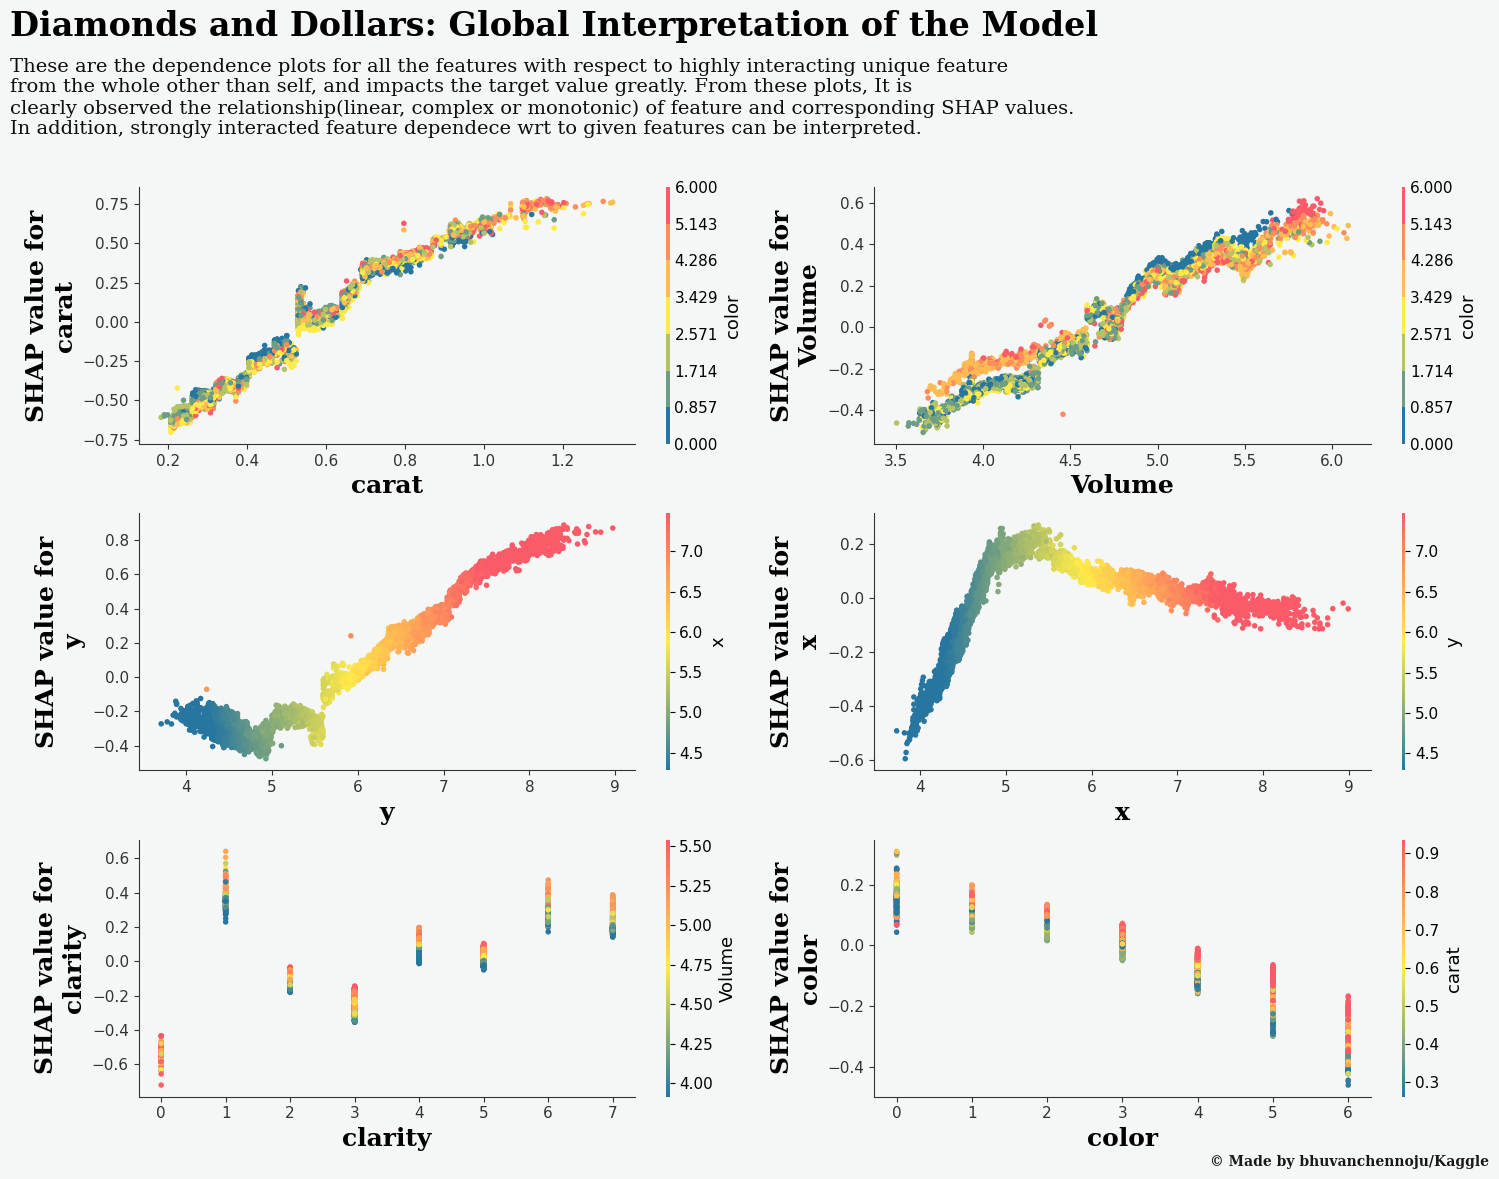

In [ ]:
fig,ax =  plt.subplots(3,2, figsize =(15,10))
fig.patch.set_facecolor('#f5f6f6')

axes = ax.ravel()
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("",colors = [colors[2],colors[1],colors[0]])
for ax,col in zip(axes,X_test.columns):
    shap.dependence_plot(col, shap_values, X_test, show = False, ax =ax,cmap = cmap1)

    ax.set_facecolor('#f5f6f6')
    ax.set_xlabel(xlabel = ax.get_xlabel(), **{'font':'serif', 'color':'black','size':18,'weight':'bold'},alpha = 1)
    ax.set_ylabel(ylabel = ax.get_ylabel(), **{'font':'serif', 'color':'black','size':18,'weight':'bold'},alpha = 1)
    #ax.set_yticklabels(ax.get_yticklabels(), **{'font':'serif', 'color':'black','size':16,'weight':'bold'},alpha = 1)


plt.tight_layout()

fig.text(-0.,1.13, 'Diamonds and Dollars: Global Interpretation of the Model',
              **{'font':'serif', 'size':24, 'weight':'bold', 'color': 'Black'})
fig.text(-0.,0.99,'''These are the dependence plots for all the features with respect to highly interacting unique feature
from the whole other than self, and impacts the target value greatly. From these plots, It is
clearly observed the relationship(linear, complex or monotonic) of feature and corresponding SHAP values.
In addition, strongly interacted feature dependece wrt to given features can be interpreted.

''',**{'font':'serif', 'size':14, 'weight':'normal', 'color': 'Black'}, alpha = 0.95)


fig.text(0.8,0.,'© Made by bhuvanchennoju/Kaggle',{'font':'serif', 'size':10, 'weight':'bold',},alpha = 0.9)
fig.show()

<br><br>
<a id = '5.4.2'></a>
<div style = "font-family: Garamond; font-size: 35px; font-weight:bold; background-color: #2676A1 ; color: #FFEB48 ; padding :10px  ">Local Intepretability of the Model:</div>
<a href = '#0' style = 'font-size:15px' align = 'right'>⏫</a>
<a href = '#5.4.1' style = 'font-size:15px' align = 'right'>🔼</a>
<a href = '#6' style = 'font-size:15px' align = 'right'>🔽</a>
<a href = '#7' style = 'font-size:15px' align = 'right'>⏬</a>
<br>
<br>
<br>

<div style = "font-family: serif; font-size: 18px; font-weight:;">With the local interpretability one can get a bigger picture in feature level,like Which direction does this features taking the target? How values of feature impacting the features? Which feature is highly contributing towards target? Which featrue in not important? <br>
<br>
    
Local Interpretation in noting but understanding of model at feature level. Thanks to SHAP functionality we can visualize how each feature contribute to final prediction can be seen clearly. As per my understanding we can put these interactions into these three level
    
<ul><li> With Mean SHAP values, understanding of Average Impact of features over the predictions  </li>
        <li> With actual SHAP values, understanding the direction feature move the prediction based on features numerical value.</li>
        <li> How much does each feature move from base values (average values) to contribute to prediction based on positive and negative impact of the feature over prediction.</li>
</ul>

To Answer this question lets examine the predictions of model with xgboost regressor, as it is giving the best score after the stacked regressor. And use SHAP module to find the shap values and visualize the results.

<br>
    
  Lets visualize the Mean SHAP valeus and impact order over the features. These are similar to feature importance given in an order of highly impacting feature to low. With these Averaged SHAP, we know that feature has impact on target, but not clear inforamtion about in sense of positive and negative impact can't be iterepted for this plot.
 <br>
 <br>
     
</div>


    
    
   

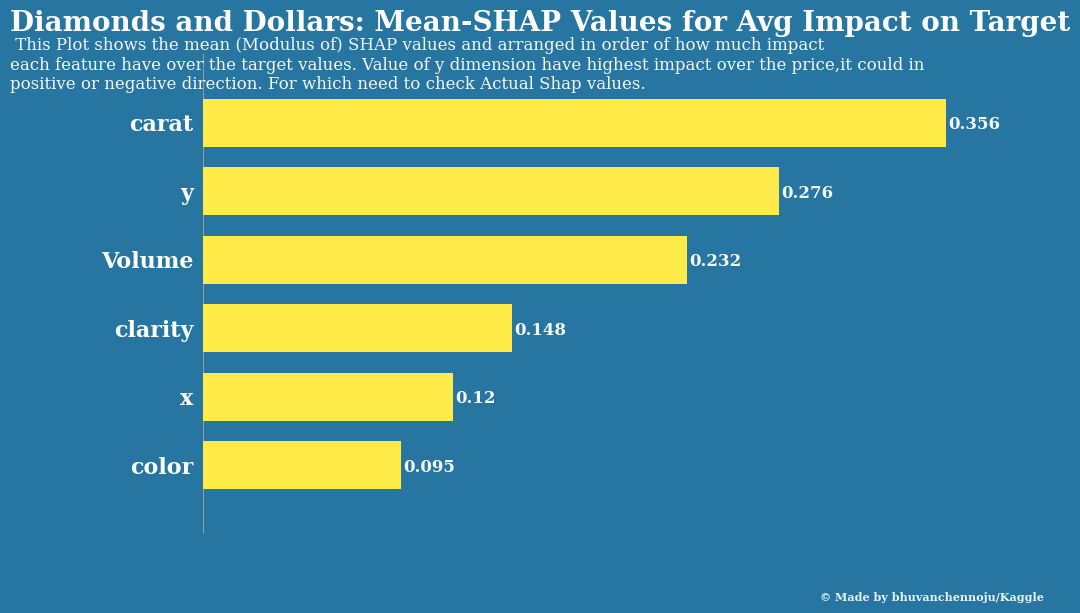

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color= colors[1], axis_color = 'white',show = False)

plt.gcf().set_size_inches(9,6)
plt.gcf().set_dpi(100)
plt.gcf().set_facecolor(colors[2])
plt.gca().set_facecolor(colors[2])
#plt.gca().set_xlabel(xlabel = plt.gca().get_xlabel(), **{'font':'serif', 'color':'white','size':16,'weight':'bold'},alpha = 1)
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), **{'font':'serif', 'color':'white','size':16,'weight':'bold'},alpha = 1)

for pa in plt.gca().patches:
        plt.gca().text((pa.get_width())+0.001, pa.get_y()+0.25,'{}'.format(round(pa.get_width(),3)),
                       **{'font':'serif', 'size':12, 'weight':'bold', 'color': 'White'}, alpha = 0.95)

plt.gca().get_xaxis().set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.gcf().text(-0.1,1, 'Diamonds and Dollars: Mean-SHAP Values for Avg Impact on Target',
              **{'font':'serif', 'size':20, 'weight':'bold', 'color': 'White'})
plt.gcf().text(-0.1,0.87,''' This Plot shows the mean (Modulus of) SHAP values and arranged in order of how much impact
each feature have over the target values. Value of y dimension have highest impact over the price,it could in
positive or negative direction. For which need to check Actual Shap values.
''',**{'font':'serif', 'size':12, 'weight':'normal', 'color': 'White'}, alpha = 0.95)
plt.gcf().text(0.8,0.05,'© Made by bhuvanchennoju/Kaggle',{'font':'serif', 'size':8, 'weight':'bold','color':'white'},alpha = 0.9)
plt.gcf().show()

<br>
<br>
<div style = "font-family: serif; font-size: 18px; font-weight:;">Lets visualise the actual SHAP values vs features plot, where
we can get the sense of the directionality factor for the prediction.
<br><br>
<p style = "font-family: serif; font-size:20px; font-weight:;"><strong>Explination of the Beeswarm Summary plot:</strong><p>
   
<ul><li><strong>Feature importance:</strong> Features are ranked in descending order.</li><br>
        <li><strong>Impact on the prediction:</strong> Position of scatter dots for a feature informs the SHAP values corresponding from Xaxis. Positive X direciton means high impact, negative X direction means low imapct .</li><br>
        <li><strong>Original value:</strong> Color shows whether that feature numerical value is high (in red) or low (in yellow) for that observation.</li><br>
        <li><strong>Correlation:</strong> Features with Positve SHAP values push towards the target, likewise feature negaitve SHAP values
pull away from the target. For instance, feature Y - Higher feature values leads
to higher SHAP values there by increase its contribution towards prediction. And lower feature
lead to lower SHAP values and decreasing its contribution. For feature color its reverse</li>
</ul>

</div>
<br>
<br>

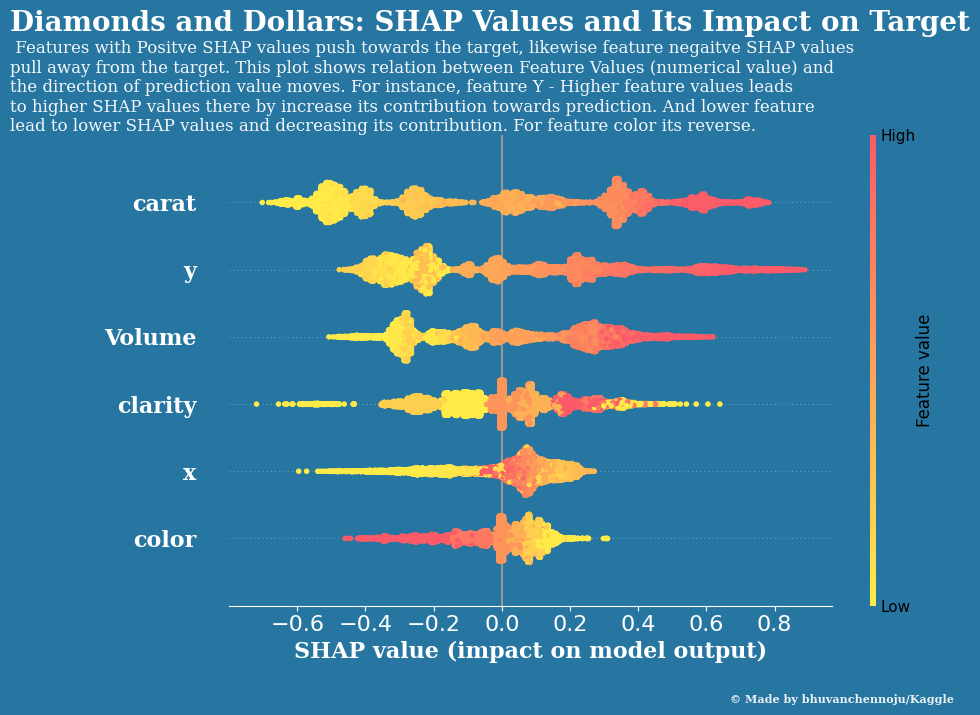

In [ ]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("",colors = [colors[1],colors[0]])
shap.summary_plot(shap_values, X_test, show = False,cmap = cmap1,axis_color = 'white')

plt.gca().tick_params(axis = 'both',colors = 'white', labelsize = '16')


plt.gcf().set_size_inches(9,6)
plt.gcf().set_dpi(100)
plt.gcf().set_facecolor(colors[2])
plt.gca().set_facecolor(colors[2])
plt.gca().set_xlabel(xlabel = plt.gca().get_xlabel(), **{'font':'serif', 'color':'white','size':16,'weight':'bold'},alpha = 1)
#plt.gca().set_xticklabels(plt.gca().get_xticklabels(), **{'font':'serif', 'color':'white','size':16,'weight':'bold'},alpha = 1)
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), **{'font':'serif', 'color':'white','size':16,'weight':'bold'},alpha = 1)

for pa in plt.gca().patches:
        plt.gca().text((pa.get_width())+0.001, pa.get_y()+0.25,'{}'.format(round(pa.get_width(),3)),
                       **{'font':'serif', 'size':12, 'weight':'bold', 'color': 'White'}, alpha = 0.95)


#plt.gca().get_xaxis().set_visible(False)
plt.gca().spines['bottom'].set_color('white')

plt.gcf().text(-0.1,1.12, 'Diamonds and Dollars: SHAP Values and Its Impact on Target',
              **{'font':'serif', 'size':20, 'weight':'bold', 'color': 'White'})
plt.gcf().text(-0.1,0.92,''' Features with Positve SHAP values push towards the target, likewise feature negaitve SHAP values
pull away from the target. This plot shows relation between Feature Values (numerical value) and
the direction of prediction value moves. For instance, feature Y - Higher feature values leads
to higher SHAP values there by increase its contribution towards prediction. And lower feature
lead to lower SHAP values and decreasing its contribution. For feature color its reverse.
''',**{'font':'serif', 'size':12, 'weight':'normal', 'color': 'White'}, alpha = 0.95)


plt.gcf().text(0.7,0.,'© Made by bhuvanchennoju/Kaggle',{'font':'serif', 'size':8, 'weight':'bold','color':'white'},alpha = 0.9)
plt.gcf().show()

<div style = "font-family: serif; font-size: 18px; font-weight:;">Finally model interpretabilty at the prediction level.
Here we can visualize how much each feature contributing towards the predictions. And here on each feature we will see the marginaral contributions of the individual features.

<br><br>

Few things to know before are base values. Base values are the predictions when made with no feature data i.e, simple average of y_test data. Based on these values, and how poistively and negitively impacting on predictions dectate the contribution of each feature.
<br>
<br>
If a feature contribution is more than marginal contributions then its push towards target, else it pull away from the target.
But, What is marginal contributions? its an average of all possible permutations of contribuitons of each feature towards target. for instance, ABC are three friends and done a work in 10 hours, now if we take each person contribution as permutations such as (1,1,8),(1,2,7), (10,0,0),(3,7,0) like these set and compute average for each person, that would give  marginal contribution of that person. So, it feature contribution > marginal contributionn its +ve impact else -ve impact.

<br><br>
    
    
lets visualize the individual feature contribution toward target.
    
<br>
</div>

In [ ]:
explainerModel = shap.TreeExplainer(model)
shap_values_Model = explainerModel.shap_values(X_test)

# Initialize Jupyter notebook with initjs()
shap.initjs();

# Write in a function
def shap_plot(j):

    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j],feature_names= ['carat', 'Volume', 'y', 'x', 'clarity', 'color'])
    return(p)
shap_plot(10)

In [ ]:
shap.initjs();
shap_plot(10)

<div style = "font-family: serif; font-size: 18px; font-weight:;">From the above figure, basevalue is mean of X_test, and red color is +ve and adds value to basevalue,and blue is -ve and substracts value from the basevalue. In this tug of war, if values contribute to increase overall value from basevalue is poistively impacted feature and if feature is contributed to reduction in overall values from basevalue it is negatively impacted feature.
    <br>
    <br>
    Simply red features are contributing towards predcition of the feature, were as blue features dampen the effect.
    <br>
    <br>
    
Lets visualize few more samples from the data.
    <br><br>
 </div>
    

In [ ]:
shap.initjs();
shap_plot(1)

In [ ]:
shap.initjs();
shap_plot(100)

In [ ]:
shap.initjs();
shap_plot(1000)

In [ ]:
shap.initjs();
shap_plot(10000)

In [ ]:
shap.initjs();
shap_plot(500)

In [ ]:
shap.initjs();
shap_plot(8000)

<a id = '6'></a>
<h1 style = "font-family: Garamond; font-size:35px; font-weight: bold; border-radius: 300px 300px; background-color: #2676A1; color : #FFEB48; padding:2px" align = 'center'> 6. Summary and Conclusions</h1>
<a href = '#0' style = 'font-size:15px' align = 'right'>⏫</a>
<a href = '#5.4.2' style = 'font-size:15px' align = 'right'>🔼</a>
<a href = '#7' style = 'font-size:15px' align = 'right'>🔽</a>
<a href = '#7' style = 'font-size:15px' align = 'right'>⏬</a>

<div style = "font-family: serif; font-size: 18px; font-weight:;">With all the analysis, visualizaitons, Modeling and interpretation of the model, now I am sure this model will give the best diamond for our guy.
<br>
Well its time to help our guy, with our little project, he got his prefect diamond, and lived happily ever after.
<br><br>

Lets revist What have we done so far?

<br>
<ul><li>First we have exposed ourself to dataset terminology, and dataset.</li>
    <li>Viewed data from statistical stand point.</li>
    <li>Find few patterns from data</li>
    <li>Fitted data to models</li>
    <li>Made sure our mode is trust worthy.</li>
   
</ul>
<br>

What else can we do in futur?
may be tunning base models and traing the stacked regressor with those base models and intrepreting stacked model if possible.

<br>
    
    
   
<p style = "font-family: Garamond; font-size: 35px; font-weight:"> <strong>Thanks for reading all the way here.............Please Up vote if you find my work useful.</strong></p>
</div>

<a id = '7'></a>
<h1 style = "font-family: Garamond; font-size:35px; font-weight: bold; border-radius: 300px 300px; background-color: #2676A1; color : #FFEB48; padding:2px" align = 'center'> 7. References</h1>
<a href = '#0' style = 'font-size:15px' align = 'right'>⏫</a>
<a href = '#6' style = 'font-size:15px' align = 'right'>🔼</a>

* [simple-matplotlib-visualization-tips](https://www.kaggle.com/subinium/simple-matplotlib-visualization-tips/comments)
* [top-50-matplotlib-visualizations-the-master-plots-python](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/)
* [simple-trick-to-select-variables-for-model](https://www.kaggle.com/michau96/simple-trick-to-select-variables-for-model)
* [feature-selection-with-null-importances](https://www.kaggle.com/ogrellier/feature-selection-with-null-importances)
* [Beware of Random Forests](https://explained.ai/rf-importance/index.html)
* [better-heatmaps-and-correlation-matrix-plots-in-python](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)
* [just-keep-stacking-implement-stacking-regression-in-python-using-mlxtend](https://towardsdatascience.com/just-keep-stacking-implement-stacking-regression-in-python-using-mlxtend-3250ff327ee5)
* [stacked-regressions-top-4-on-leaderboard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [why-should-i-trust-your-model](https://medium.com/analytics-vidhya/why-should-i-trust-your-model-bdda6be94c6f)
* [feature-selection-with-permutation-importance](https://www.kaggle.com/paultimothymooney/feature-selection-with-permutation-importance)
* [create-beautiful-notebooks-formatting-tutorial](https://www.kaggle.com/shubhamksingh/create-beautiful-notebooks-formatting-tutorial)
* [explain-your-model-with-the-shap-values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
* [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874#:~:text=Understanding%20why%20a%20model%20makes,prediction's%20accuracy%20in%20many%20applications.&text=SHAP%20assigns%20each%20feature%20an%20importance%20value%20for%20a%20particular%20prediction.)
* [shap-explained-the-way-i-wish-someone-explained-it-to-me](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30#:~:text=In%20a%20nutshell%2C%20SHAP%20values,answer%20the%20%E2%80%9Chow%20much%E2%80%9D.)
* [shap github source code](https://github.com/slundberg/shap/blob/master/shap/plots/_beeswarm.py)